# EEG - Alcohol

# 1. Tiền xử lý dữ liệu

Phần này gồm:
- Đọc danh sách file train/test
- Chuẩn hoá dữ liệu dạng long-table
- Tạo epoch matrix (channel × time)
- Trích xuất đặc trưng (bandpower + spectrogram)


## Merge dữ liệu

### 1. Merge dữ liệu cho tập train 

In [1]:
RANDOM_STATE = 42

In [2]:
import pandas as pd
import glob
import os

In [3]:
path = 'SMNI_CMI_TRAIN/Train'
all_file = glob.glob(os.path.join(path, "*.csv"), recursive=True)

In [4]:
print(f"there'r {len(all_file)} files in {path} folder")

there'r 468 files in SMNI_CMI_TRAIN/Train folder


In [5]:
# Không concat toàn bộ file (rất nặng). Chỉ tạo danh sách file để xử lý theo từng file.
train_files = all_file
print('n_train_files:', len(train_files))
print('sample train files:', train_files[:3])

n_train_files: 468
sample train files: ['SMNI_CMI_TRAIN/Train\\Data1.csv', 'SMNI_CMI_TRAIN/Train\\Data10.csv', 'SMNI_CMI_TRAIN/Train\\Data100.csv']


Dữ liệu train khá lớn nếu concat toàn bộ vào 1 DataFrame (~7.6 triệu dòng).

Trong pipeline **cách A**, mình xử lý **theo từng file** để trích xuất đặc trưng (bandpower + spectrogram tensor), tránh `KeyboardInterrupt`/tốn RAM.

### 2. Merge dữ liệu cho tập test

In [6]:
path = 'SMNI_CMI_TEST/Test'
all_file = glob.glob(os.path.join(path, "*.csv"), recursive=True)

In [7]:
print(f"there'r {len(all_file)} files in {path} folder")

there'r 480 files in SMNI_CMI_TEST/Test folder


# 2. Phân tích dữ liệu (EDA) & biểu diễn miền tần số

Phần này trực quan hoá và phân tích đặc trưng miền tần số/time-frequency để hiểu dữ liệu:
- PSD (Welch)
- Bandpower theo dải tần
- Spectrogram


In [8]:
# Không concat toàn bộ file test. Chỉ tạo danh sách file.
test_files = all_file
print('n_test_files:', len(test_files))
print('sample test files:', test_files[:3])

n_test_files: 480
sample test files: ['SMNI_CMI_TEST/Test\\Data1.csv', 'SMNI_CMI_TEST/Test\\Data10.csv', 'SMNI_CMI_TEST/Test\\Data100.csv']


## Biểu diễn miền tần số / time-frequency (giữ thông tin thời gian)

Phần trước đang nén mỗi file thành `mean/std/min/max` nên mất cấu trúc theo thời gian và phổ tần.

Trong phần này mình sẽ:
1. Tổ chức lại dữ liệu thành **epoch theo từng trial**: `(trial, channel, sample)`.
2. Trích xuất phổ tần bằng **Welch PSD** (tần số) và **Spectrogram/STFT** (tần số theo thời gian).
3. Trực quan hoá và so sánh theo nhãn.
4. Dùng cùng pipeline dữ liệu này cho:
   - ML cổ điển (LogReg/RF/XGB) trên vector feature tần số.
   - Deep Learning (CNN) trên ảnh spectrogram.


In [9]:
import numpy as np
import pandas as pd

from scipy.signal import welch, spectrogram

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
FS = 256  # Hz, suy ra từ bước time = 0.003906 ~ 1/256
N_SAMPLES = 256

BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45),
}

np.random.seed(RANDOM_STATE)

In [10]:
from typing import Optional, Tuple, List


def normalize_long_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()
    df['label'] = df['subject identifier'].map({'a': 1, 'c': 0})
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df.rename(columns={'sensor_position': 'channel', 'channel': 'channel_id'}, inplace=True)
    return df


def build_epoch_matrix_from_long(df_long: pd.DataFrame, trial_number: Optional[int] = None, channels_keep=None) -> Tuple[np.ndarray, List[str]]:
    sub = df_long
    if trial_number is not None:
        sub = sub[sub['trial_number'] == trial_number]
    if channels_keep is not None:
        sub = sub[sub['channel'].isin(channels_keep)]

    mat = sub.pivot_table(index='channel', columns='sample_num', values='sensor_value', aggfunc='mean')
    mat = mat.reindex(columns=list(range(N_SAMPLES)))

    missing_ratio = mat.isna().mean(axis=1)
    mat = mat[missing_ratio < 0.05]

    mat = mat.interpolate(axis=1, limit_direction='both').bfill(axis=1).ffill(axis=1)

    return mat.values.astype(np.float32), mat.index.tolist()


def welch_psd_features(x_ch_t: np.ndarray, fs=FS, nperseg=128):
    freqs, psd = welch(x_ch_t, fs=fs, nperseg=nperseg, axis=1)
    return freqs.astype(np.float32), psd.astype(np.float32)


def bandpower(psd: np.ndarray, freqs: np.ndarray, band):
    from scipy.integrate import trapezoid

    lo, hi = band
    mask = (freqs >= lo) & (freqs <= hi)
    if mask.sum() < 2:
        return np.zeros((psd.shape[0],), dtype=np.float32)
    return trapezoid(psd[:, mask], freqs[mask], axis=1).astype(np.float32)


def spectrogram_tf(x_ch_t: np.ndarray, fs=FS, nperseg=64, noverlap=48, nfft=256, fmax=45):
    C, _ = x_ch_t.shape
    all_sxx = []
    for c in range(C):
        f, t, Sxx = spectrogram(
            x_ch_t[c],
            fs=fs,
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft,
            scaling='density',
            mode='psd',
        )
        all_sxx.append(Sxx)

    f = f.astype(np.float32)
    t = t.astype(np.float32)
    S = np.stack(all_sxx, axis=0).astype(np.float32)

    if fmax is not None:
        m = f <= fmax
        f = f[m]
        S = S[:, m, :]

    return f, t, S


def extract_features_from_file(file_path: str):
    df_raw = pd.read_csv(file_path)
    df_raw['source_file'] = os.path.basename(file_path)
    df_long = normalize_long_df(df_raw)

    trial_number = int(df_long['trial_number'].iloc[0])
    label = int(df_long['label'].iloc[0])
    source_file = str(df_long['source_file'].iloc[0])

    x_ch_t, ch_names = build_epoch_matrix_from_long(df_long, trial_number=trial_number)

    # Time-domain statistics theo kênh: mean/std/min/max
    td_mean = x_ch_t.mean(axis=1)
    td_std = x_ch_t.std(axis=1)
    td_min = x_ch_t.min(axis=1)
    td_max = x_ch_t.max(axis=1)

    td_feats = []
    td_cols = []
    for ci, ch in enumerate(ch_names):
        td_feats.extend([td_mean[ci], td_std[ci], td_min[ci], td_max[ci]])
        td_cols.extend([
            f'td_mean_{ch}',
            f'td_std_{ch}',
            f'td_min_{ch}',
            f'td_max_{ch}',
        ])
    td_feats = np.asarray(td_feats, dtype=np.float32)

    freqs, psd = welch_psd_features(x_ch_t, fs=FS, nperseg=128)
    bp_feats = []
    bp_cols = []
    for bname, brange in BANDS.items():
        bp = bandpower(psd, freqs, brange)
        for ci, ch in enumerate(ch_names):
            bp_feats.append(bp[ci])
            bp_cols.append(f'bp_{bname}_{ch}')

    bp_feats = np.array(bp_feats, dtype=np.float32)

    f, t, S = spectrogram_tf(x_ch_t, fs=FS, nperseg=64, noverlap=48, nfft=256, fmax=45)
    S_img = np.log10(S.mean(axis=0) + 1e-12).astype(np.float32)  # (F,T)

    return {
        'source_file': source_file,
        'trial_number': trial_number,
        'label': label,
        'td_feats': td_feats,
        'td_cols': td_cols,
        'bp_feats': bp_feats,
        'bp_cols': bp_cols,
        'spec_img': S_img,
        'spec_f': f,
        'spec_t': t,
        'ch_names': ch_names,
    }


print('Functions ready (streaming per file).')


Functions ready (streaming per file).


In [11]:
# Kiểm tra cấu trúc nhanh theo vài file (streaming) để đảm bảo mỗi file có đủ 64 kênh và 256 mẫu

def summarize_files(file_paths, n_files=8):
    rows = []
    for fp in file_paths[:n_files]:
        df_raw = pd.read_csv(fp)
        df_raw['source_file'] = os.path.basename(fp)
        df_long = normalize_long_df(df_raw)

        rows.append({
            'source_file': os.path.basename(fp),
            'trial_number': int(df_long['trial_number'].iloc[0]),
            'label': int(df_long['label'].iloc[0]),
            'n_channels': int(df_long['channel'].nunique()),
            'n_sample_nums': int(df_long['sample_num'].nunique()),
            'n_rows': int(len(df_long)),
        })

    return pd.DataFrame(rows)

file_summary = summarize_files(train_files, n_files=8)
file_summary

,source_file,trial_number,label,n_channels,n_sample_nums,n_rows
0,Data1.csv,0,1,64,256,16384
1,Data10.csv,18,1,64,256,16384
2,Data100.csv,13,1,64,256,16384
3,Data101.csv,14,1,64,256,16384
4,Data102.csv,15,1,64,256,16384
5,Data103.csv,16,1,64,256,16384
6,Data104.csv,17,1,64,256,16384
7,Data105.csv,18,1,64,256,16384


## EDA nhanh (dễ nhìn – dễ hiểu)

Mục tiêu phần này:
- Cho người xem thấy **dữ liệu gốc** trông như thế nào (một vài dòng)
- Thấy **phân phối nhãn** (a/c) và số lượng trial
- Trực quan **tín hiệu theo thời gian** (vài kênh)
- Trực quan **PSD/bandpower** và **spectrogram** cho 1 file mẫu


Tổng số file:
  TRAIN: 468
  TEST : 480
Phân phối nhãn (quick) (0=c, 1=a):
  TRAIN: [233 235]
  TEST : [240 240]


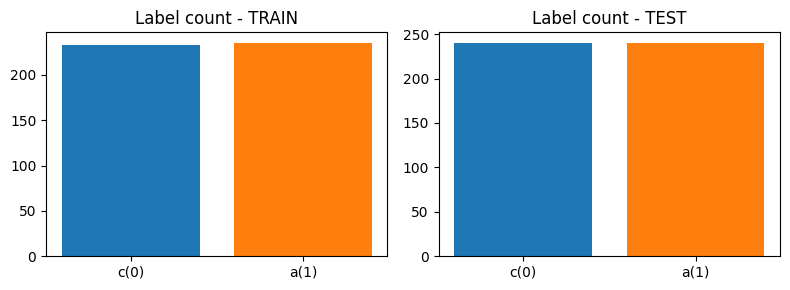

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Tổng quan số file + phân phối nhãn (đọc nhẹ 1 vài dòng đầu mỗi file)

def quick_label(fp):
    df0 = pd.read_csv(fp, nrows=5)
    y = df0['subject identifier'].iloc[0]
    return 1 if y == 'a' else 0

train_labels_quick = np.array([quick_label(fp) for fp in train_files], dtype=int)
test_labels_quick = np.array([quick_label(fp) for fp in test_files], dtype=int)

print('Tổng số file:')
print('  TRAIN:', len(train_files))
print('  TEST :', len(test_files))
print('Phân phối nhãn (quick) (0=c, 1=a):')
print('  TRAIN:', np.bincount(train_labels_quick))
print('  TEST :', np.bincount(test_labels_quick))

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.bar(['c(0)', 'a(1)'], np.bincount(train_labels_quick), color=['tab:blue', 'tab:orange'])
plt.title('Label count - TRAIN')
plt.subplot(1, 2, 2)
plt.bar(['c(0)', 'a(1)'], np.bincount(test_labels_quick), color=['tab:blue', 'tab:orange'])
plt.title('Label count - TEST')
plt.tight_layout()
plt.show()


In [13]:
# 2) Xem dữ liệu gốc của 1 file (để người xem hiểu schema)
sample_fp = train_files[0]
df_raw_head = pd.read_csv(sample_fp).head(10)
print('File mẫu:', sample_fp)
display(df_raw_head)

# 3) Xem dữ liệu sau normalize (tên cột chuẩn hoá)
df_norm = normalize_long_df(pd.read_csv(sample_fp).assign(source_file=os.path.basename(sample_fp)))
print('Sau normalize (head):')
display(df_norm.head(10))


File mẫu: SMNI_CMI_TRAIN/Train\Data1.csv


,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,6,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,7,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,8,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,9,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625
5,10,0,FP1,5,14.028,a,S1 obj,0,co2a0000364,0.019531
6,11,0,FP1,6,11.587,a,S1 obj,0,co2a0000364,0.023438
7,12,0,FP1,7,6.704,a,S1 obj,0,co2a0000364,0.027344
8,13,0,FP1,8,1.821,a,S1 obj,0,co2a0000364,0.031250
9,14,0,FP1,9,-1.109,a,S1 obj,0,co2a0000364,0.035156


Sau normalize (head):


,unnamed:_0,trial_number,channel,sample_num,sensor_value,subject_identifier,matching_condition,channel_id,name,time,source_file,label
0,5,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000,Data1.csv,1
1,6,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906,Data1.csv,1
2,7,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812,Data1.csv,1
3,8,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719,Data1.csv,1
4,9,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625,Data1.csv,1
5,10,0,FP1,5,14.028,a,S1 obj,0,co2a0000364,0.019531,Data1.csv,1
6,11,0,FP1,6,11.587,a,S1 obj,0,co2a0000364,0.023438,Data1.csv,1
7,12,0,FP1,7,6.704,a,S1 obj,0,co2a0000364,0.027344,Data1.csv,1
8,13,0,FP1,8,1.821,a,S1 obj,0,co2a0000364,0.031250,Data1.csv,1
9,14,0,FP1,9,-1.109,a,S1 obj,0,co2a0000364,0.035156,Data1.csv,1


sample_path: SMNI_CMI_TRAIN/Train\Data1.csv
trial: 0 label: 1
epoch matrix shape (C,T): (64, 256)
n_channels: 64 first 10: ['AF1', 'AF2', 'AF7', 'AF8', 'AFZ', 'C1', 'C2', 'C3', 'C4', 'C5']


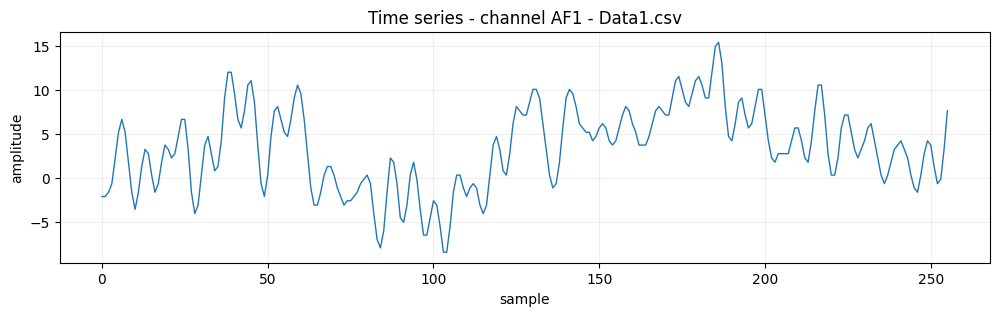

In [14]:
# Chọn 1 file mẫu để trực quan hoá
sample_path = train_files[0]
print('sample_path:', sample_path)

# Đọc file mẫu -> dựng epoch matrix
_df_raw = pd.read_csv(sample_path)
_df_raw['source_file'] = os.path.basename(sample_path)
_df_long = normalize_long_df(_df_raw)

_sample_trial = int(_df_long['trial_number'].iloc[0])
_sample_label = int(_df_long['label'].iloc[0])

x_ch_t, ch_names = build_epoch_matrix_from_long(_df_long, trial_number=_sample_trial)
print('trial:', _sample_trial, 'label:', _sample_label)
print('epoch matrix shape (C,T):', x_ch_t.shape)
print('n_channels:', len(ch_names), 'first 10:', ch_names[:10])

# Vẽ chuỗi thời gian 1 kênh
plt.figure(figsize=(12, 3))
plt.plot(x_ch_t[0], linewidth=1)
plt.title(f'Time series - channel {ch_names[0]} - {os.path.basename(sample_path)}')
plt.xlabel('sample')
plt.ylabel('amplitude')
plt.grid(alpha=0.2)
plt.show()

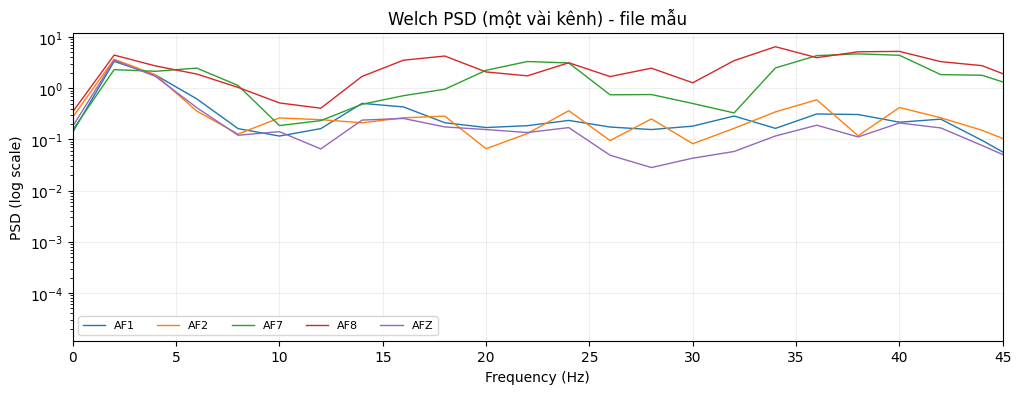

,channel,delta,theta,alpha,beta,gamma
0,AF1,5.167015,3.221890,0.558470,3.824287,3.358711
1,AF2,5.520838,2.676154,0.897204,3.210297,4.052725
2,AF7,4.456908,8.239565,1.740331,24.741901,38.563766
3,AF8,7.183810,7.567124,2.482440,40.875393,59.340298
4,AFZ,5.239593,2.663049,0.470358,2.229044,1.828981


In [15]:
# PSD (Welch) cho file mẫu + so sánh các band
freqs, psd = welch_psd_features(x_ch_t, fs=FS, nperseg=128)

plt.figure(figsize=(12, 4))
for i in range(min(5, psd.shape[0])):
    plt.semilogy(freqs, psd[i], label=ch_names[i], linewidth=1)
plt.xlim(0, 45)
plt.title('Welch PSD (một vài kênh) - file mẫu')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (log scale)')
plt.grid(alpha=0.2)
plt.legend(ncol=5, fontsize=8)
plt.show()

# Bandpower cho 1 epoch mẫu: mỗi band -> vector theo kênh
bp = {}
for bname, brange in BANDS.items():
    bp[bname] = bandpower(psd, freqs, brange)

bp_df = pd.DataFrame(bp)
bp_df.insert(0, 'channel', ch_names)
bp_df.head()

Sample label=0 (c): SMNI_CMI_TRAIN/Train\Data236.csv
Sample label=1 (a): SMNI_CMI_TRAIN/Train\Data1.csv


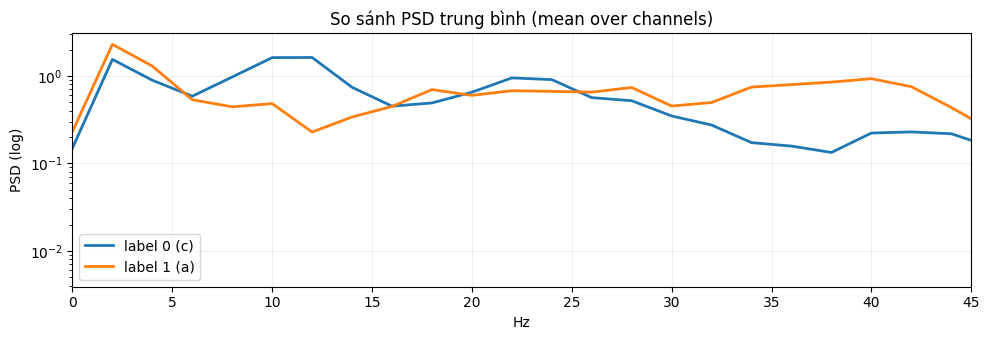

,band,label0_c_mean,label1_a_mean
0,delta,2.434564,3.585406
1,theta,3.035472,2.804906
2,alpha,5.830358,1.635142
3,beta,10.152578,9.742800
4,gamma,2.945205,10.024077


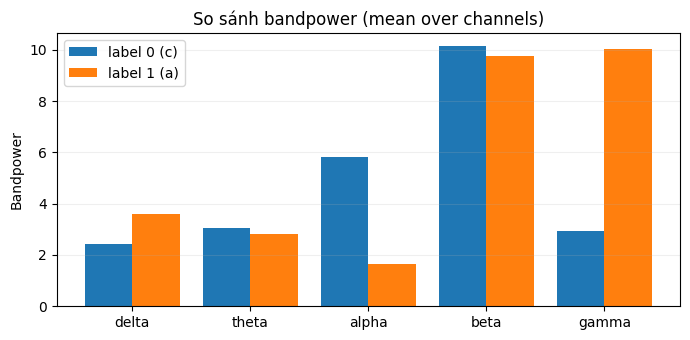

In [16]:
# So sánh nhanh 2 mẫu khác nhãn (c vs a): PSD + bandpower

def find_first_file_by_label(file_list, target_label):
    for fp in file_list:
        if quick_label(fp) == target_label:
            return fp
    return None

fp_c = find_first_file_by_label(train_files, 0)
fp_a = find_first_file_by_label(train_files, 1)
print('Sample label=0 (c):', fp_c)
print('Sample label=1 (a):', fp_a)

# Dựng epoch cho mỗi mẫu

def load_epoch(fp):
    df_raw = pd.read_csv(fp)
    df_raw['source_file'] = os.path.basename(fp)
    df_long = normalize_long_df(df_raw)
    trial = int(df_long['trial_number'].iloc[0])
    x, ch = build_epoch_matrix_from_long(df_long, trial_number=trial)
    return x, ch, trial

x_c, ch_c, trial_c = load_epoch(fp_c)
x_a, ch_a, trial_a = load_epoch(fp_a)

# PSD trung bình theo kênh
freqs_c, psd_c = welch_psd_features(x_c, fs=FS, nperseg=128)
freqs_a, psd_a = welch_psd_features(x_a, fs=FS, nperseg=128)

plt.figure(figsize=(10, 3.5))
plt.semilogy(freqs_c, psd_c.mean(axis=0), label='label 0 (c)', linewidth=2)
plt.semilogy(freqs_a, psd_a.mean(axis=0), label='label 1 (a)', linewidth=2)
plt.xlim(0, 45)
plt.title('So sánh PSD trung bình (mean over channels)')
plt.xlabel('Hz')
plt.ylabel('PSD (log)')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# Bandpower: trung bình theo kênh cho từng band
bp_rows = []
for bname, brange in BANDS.items():
    bp0 = bandpower(psd_c, freqs_c, brange).mean()
    bp1 = bandpower(psd_a, freqs_a, brange).mean()
    bp_rows.append({'band': bname, 'label0_c_mean': float(bp0), 'label1_a_mean': float(bp1)})

bp_cmp = pd.DataFrame(bp_rows)
display(bp_cmp)

plt.figure(figsize=(7, 3.5))
xpos = np.arange(len(bp_cmp))
plt.bar(xpos - 0.2, bp_cmp['label0_c_mean'], width=0.4, label='label 0 (c)')
plt.bar(xpos + 0.2, bp_cmp['label1_a_mean'], width=0.4, label='label 1 (a)')
plt.xticks(xpos, bp_cmp['band'], rotation=0)
plt.title('So sánh bandpower (mean over channels)')
plt.ylabel('Bandpower')
plt.grid(axis='y', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


# 3. Triển khai mô hình

Phần này gồm:
- Tách train/test theo `groups` để tránh leakage
- Huấn luyện các mô hình ML cổ điển trên bandpower
- Huấn luyện các mô hình Deep Learning trên spectrogram


spectrogram shape (C,F,T): (64, 46, 7)


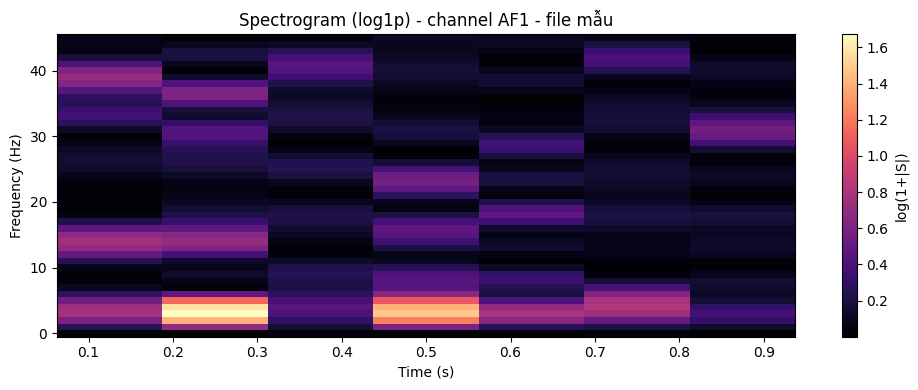

In [17]:
# Spectrogram (time-frequency) cho file mẫu
f, t, S = spectrogram_tf(x_ch_t, fs=FS, nperseg=64, noverlap=32, fmax=45)
print('spectrogram shape (C,F,T):', S.shape)

ch_idx = 0
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, np.log1p(S[ch_idx]), shading='auto', cmap='magma')
plt.title(f'Spectrogram (log1p) - channel {ch_names[ch_idx]} - file mẫu')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.colorbar(label='log(1+|S|)')
plt.tight_layout()
plt.show()

## 3.1 Mô hình ML cổ điển (Bandpower)

So sánh Logistic Regression / Random Forest / XGBoost / KNN trên vector bandpower.

In [18]:
# Build dataset: tách riêng TRAIN (SMNI_CMI_TRAIN) và TEST/VALID (SMNI_CMI_TEST)
# IMPORTANT: Dataset này có 1 phần file TEST bị trùng nội dung với TRAIN (leak).
# Ở đây mình lọc bỏ các file TEST có MD5 trùng với bất kỳ file TRAIN nào.

import hashlib

# Để chạy nhanh khi thử nghiệm
MAX_FILES_TRAIN = None  # ví dụ: 200
MAX_FILES_TEST = None   # ví dụ: 200

REMOVE_TEST_DUPLICATES = True  # set False nếu bạn muốn so sánh trước/sau

train_use = train_files
raw_test_use = test_files

if MAX_FILES_TRAIN is not None:
    rng = np.random.default_rng(RANDOM_STATE)
    train_use = list(rng.choice(train_use, size=min(MAX_FILES_TRAIN, len(train_use)), replace=False))
if MAX_FILES_TEST is not None:
    rng = np.random.default_rng(RANDOM_STATE)
    raw_test_use = list(rng.choice(raw_test_use, size=min(MAX_FILES_TEST, len(raw_test_use)), replace=False))


def file_md5(path, chunk_size=1024 * 1024):
    h = hashlib.md5()
    with open(path, 'rb') as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()


def filter_test_duplicates(train_paths, test_paths):
    train_md5 = set(file_md5(p) for p in train_paths)
    keep = []
    dropped = []
    for p in test_paths:
        m = file_md5(p)
        if m in train_md5:
            dropped.append(p)
        else:
            keep.append(p)
    return keep, dropped


if REMOVE_TEST_DUPLICATES:
    print('Filtering TEST duplicates by MD5 (content)...')
    test_use, dropped_test = filter_test_duplicates(train_use, raw_test_use)
    print('  raw_test:', len(raw_test_use))
    print('  kept   :', len(test_use))
    print('  dropped:', len(dropped_test))
    if len(dropped_test) > 0:
        print('  sample dropped:', [os.path.basename(x) for x in dropped_test[:10]])
else:
    test_use = raw_test_use
    dropped_test = []


def build_dataset_from_files(files_use, td_cols_ref=None, bp_cols_ref=None, spec_f_ref=None, spec_t_ref=None):
    X_td_list = []
    X_bp_list = []
    X_spec_list = []
    y_list = []
    groups_list = []

    skipped = 0
    for fp in files_use:
        out = extract_features_from_file(fp)

        if td_cols_ref is None:
            td_cols_ref = out['td_cols']
        elif out['td_cols'] != td_cols_ref:
            skipped += 1
            continue

        if bp_cols_ref is None:
            bp_cols_ref = out['bp_cols']
        elif out['bp_cols'] != bp_cols_ref:
            skipped += 1
            continue

        if spec_f_ref is None:
            spec_f_ref = out['spec_f']
            spec_t_ref = out['spec_t']
        else:
            if out['spec_img'].shape != (len(spec_f_ref), len(spec_t_ref)):
                skipped += 1
                continue

        X_td_list.append(out['td_feats'])
        X_bp_list.append(out['bp_feats'])
        X_spec_list.append(out['spec_img'])
        y_list.append(out['label'])
        groups_list.append(out['source_file'])

    X_td = np.stack(X_td_list, axis=0)
    X_bp = np.stack(X_bp_list, axis=0)
    X_spec = np.stack(X_spec_list, axis=0)[..., np.newaxis]  # (N,F,T,1)
    y = np.array(y_list, dtype=np.int64)
    groups = np.array(groups_list)

    return X_td, X_bp, X_spec, y, groups, td_cols_ref, bp_cols_ref, spec_f_ref, spec_t_ref, skipped


# Build train set
X_td_train, X_bp_train, X_spec_train, y_train, groups_train, td_cols_ref, bp_cols_ref, spec_f_ref, spec_t_ref, skipped_train = build_dataset_from_files(
    train_use,
    td_cols_ref=None,
    bp_cols_ref=None,
    spec_f_ref=None,
    spec_t_ref=None,
)

# Build test/valid set using the same schema as train
X_td_test, X_bp_test, X_spec_test, y_test, groups_test, td_cols_ref, bp_cols_ref, spec_f_ref, spec_t_ref, skipped_test = build_dataset_from_files(
    test_use,
    td_cols_ref=td_cols_ref,
    bp_cols_ref=bp_cols_ref,
    spec_f_ref=spec_f_ref,
    spec_t_ref=spec_t_ref,
)

# Keep aliases used by downstream EDA/CV code: X_bp/y/groups refer to TRAIN
X_bp = X_bp_train
X_spec = X_spec_train
y = y_train
groups = groups_train

print('Built dataset (separate train/test)')
print('  TRAIN N:', len(y_train), 'skipped:', skipped_train)
print('    X_td_train:', X_td_train.shape)
print('    X_bp_train:', X_bp_train.shape)
print('    X_spec_train:', X_spec_train.shape)
print('  TEST  N:', len(y_test), 'skipped:', skipped_test)
print('    X_td_test:', X_td_test.shape)
print('    X_bp_test:', X_bp_test.shape)
print('    X_spec_test:', X_spec_test.shape)


Filtering TEST duplicates by MD5 (content)...
  raw_test: 480
  kept   : 456
  dropped: 24
  sample dropped: ['Data250.csv', 'Data252.csv', 'Data256.csv', 'Data258.csv', 'Data259.csv', 'Data317.csv', 'Data338.csv', 'Data342.csv', 'Data343.csv', 'Data344.csv']
Built dataset (separate train/test)
  TRAIN N: 468 skipped: 0
    X_td_train: (468, 256)
    X_bp_train: (468, 320)
    X_spec_train: (468, 46, 13, 1)
  TEST  N: 456 skipped: 0
    X_td_test: (456, 256)
    X_bp_test: (456, 320)
    X_spec_test: (456, 46, 13, 1)


## Kiểm tra leakage / độ độc lập Train vs Test

Mục tiêu:
- Xác nhận train/test **không trùng nội dung file** (dựa trên hash)
- Kiểm tra trùng basename (Data1.csv) chỉ là trùng tên hay trùng dữ liệu
- Tóm tắt phân phối nhãn train/test


In [19]:
import os
import hashlib
import pandas as pd
import numpy as np


def file_md5(path, chunk_size=1024 * 1024):
    h = hashlib.md5()
    with open(path, 'rb') as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()


def build_file_index(file_paths):
    rows = []
    for fp in file_paths:
        rows.append({
            'path': fp,
            'basename': os.path.basename(fp),
            'size': os.path.getsize(fp),
            'md5': file_md5(fp),
        })
    return pd.DataFrame(rows)


print('Indexing train/test files (hashing)...')
train_index = build_file_index(train_files)
test_index = build_file_index(test_files)

print('Train files:', len(train_index), 'Test files:', len(test_index))

# 1) Basename overlap (can be true even if content is different)
basename_overlap = set(train_index['basename']).intersection(set(test_index['basename']))
print('Basename overlap count:', len(basename_overlap))
if len(basename_overlap) > 0:
    print('Sample basenames:', sorted(list(basename_overlap))[:10])

# 2) Content overlap by md5 (this indicates true duplication)
md5_overlap = set(train_index['md5']).intersection(set(test_index['md5']))
print('MD5(content) overlap count:', len(md5_overlap))

if len(md5_overlap) > 0:
    # show a few duplicated pairs
    dup_md5 = list(md5_overlap)[:5]
    for m in dup_md5:
        tr = train_index[train_index['md5'] == m].iloc[0]
        te = test_index[test_index['md5'] == m].iloc[0]
        print('DUPLICATE CONTENT')
        print('  train:', tr['path'])
        print('  test :', te['path'])

# 3) Label distribution difference (quick shift check)
print('Label distribution (train):', np.bincount(y_train))
print('Label distribution (test): ', np.bincount(y_test))


Indexing train/test files (hashing)...
Train files: 468 Test files: 480
Basename overlap count: 468
Sample basenames: ['Data1.csv', 'Data10.csv', 'Data100.csv', 'Data101.csv', 'Data102.csv', 'Data103.csv', 'Data104.csv', 'Data105.csv', 'Data106.csv', 'Data107.csv']
MD5(content) overlap count: 24
DUPLICATE CONTENT
  train: SMNI_CMI_TRAIN/Train\Data347.csv
  test : SMNI_CMI_TEST/Test\Data345.csv
DUPLICATE CONTENT
  train: SMNI_CMI_TRAIN/Train\Data342.csv
  test : SMNI_CMI_TEST/Test\Data342.csv
DUPLICATE CONTENT
  train: SMNI_CMI_TRAIN/Train\Data60.csv
  test : SMNI_CMI_TEST/Test\Data45.csv
DUPLICATE CONTENT
  train: SMNI_CMI_TRAIN/Train\Data86.csv
  test : SMNI_CMI_TEST/Test\Data75.csv
DUPLICATE CONTENT
  train: SMNI_CMI_TRAIN/Train\Data351.csv
  test : SMNI_CMI_TEST/Test\Data349.csv
Label distribution (train): [233 235]
Label distribution (test):  [223 233]


In [20]:
# 4) Kiểm tra overlap theo subject/trial (đọc rất nhẹ: chỉ 1 vài dòng đầu)

def quick_meta(fp):
    df0 = pd.read_csv(fp, nrows=5)
    # giữ nguyên tên cột gốc để tránh phụ thuộc normalize
    subj = df0['subject identifier'].iloc[0] if 'subject identifier' in df0.columns else None
    trial = int(df0['trial number'].iloc[0]) if 'trial number' in df0.columns else None
    return subj, trial

train_meta = []
for fp in train_files:
    subj, trial = quick_meta(fp)
    train_meta.append({'basename': os.path.basename(fp), 'subject': subj, 'trial': trial})
train_meta = pd.DataFrame(train_meta)

test_meta = []
for fp in test_files:
    subj, trial = quick_meta(fp)
    test_meta.append({'basename': os.path.basename(fp), 'subject': subj, 'trial': trial})
test_meta = pd.DataFrame(test_meta)

subj_overlap = set(train_meta['subject']).intersection(set(test_meta['subject']))
print('Subject overlap count:', len(subj_overlap))
print('Sample subjects:', list(sorted(subj_overlap))[:10])

# Overlap theo (subject, trial)
pairs_train = set(zip(train_meta['subject'], train_meta['trial']))
pairs_test = set(zip(test_meta['subject'], test_meta['trial']))
pair_overlap = pairs_train.intersection(pairs_test)
print('(subject,trial) overlap count:', len(pair_overlap))
if len(pair_overlap) > 0:
    print('Sample overlapping pairs:', list(pair_overlap)[:10])


Subject overlap count: 2
Sample subjects: ['a', 'c']
(subject,trial) overlap count: 54
Sample overlapping pairs: [('c', 24), ('c', 30), ('a', 61), ('c', 97), ('c', 36), ('c', 39), ('c', 45), ('c', 51), ('a', 24), ('c', 57)]



=== Distribution shift diagnostics (TRAIN vs TEST) ===
X_bp_train: (468, 320) X_bp_test: (456, 320)
X_spec_train: (468, 46, 13, 1) X_spec_test: (456, 46, 13, 1)

[A] Top feature lệch mean nhiều nhất (bandpower):
- bp_delta_X: |mean_tr-mean_te|=28.08 | tr_mean=77.62 te_mean=49.53 | tr_std=245 te_std=114.5
- bp_theta_X: |mean_tr-mean_te|=13.06 | tr_mean=46.52 te_mean=33.45 | tr_std=141.3 te_std=75.33
- bp_delta_FPZ: |mean_tr-mean_te|=6.82 | tr_mean=25.45 te_mean=18.63 | tr_std=64.26 te_std=33.51
- bp_delta_nd: |mean_tr-mean_te|=6.729 | tr_mean=23.85 te_mean=17.12 | tr_std=62.27 te_std=35.25
- bp_delta_FP1: |mean_tr-mean_te|=6.325 | tr_mean=25.63 te_mean=19.3 | tr_std=64.56 te_std=37.25
- bp_delta_FP2: |mean_tr-mean_te|=6.294 | tr_mean=25.14 te_mean=18.84 | tr_std=62.34 te_std=32
- bp_delta_AF7: |mean_tr-mean_te|=4.565 | tr_mean=20.6 te_mean=16.03 | tr_std=47.54 te_std=25.69
- bp_delta_AF8: |mean_tr-mean_te|=4.082 | tr_mean=19.23 te_mean=15.14 | tr_std=45.87 te_std=18.8
- bp_beta_FP1: |m

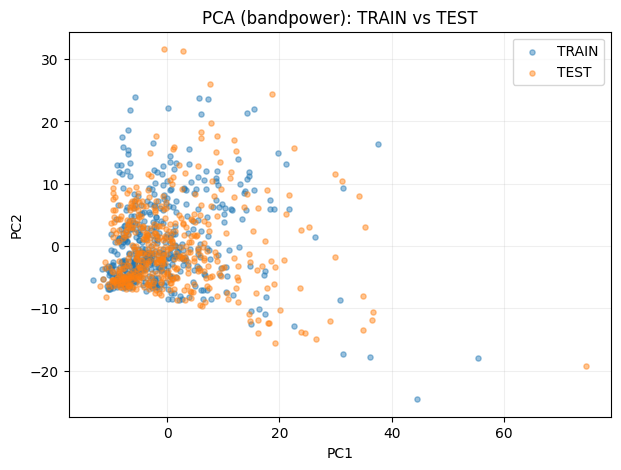


[C] Spectrogram (raw) stats:
  TRAIN mean/std: -0.6480711698532104 0.5768234133720398
  TEST  mean/std: -0.633563220500946 0.5901613235473633


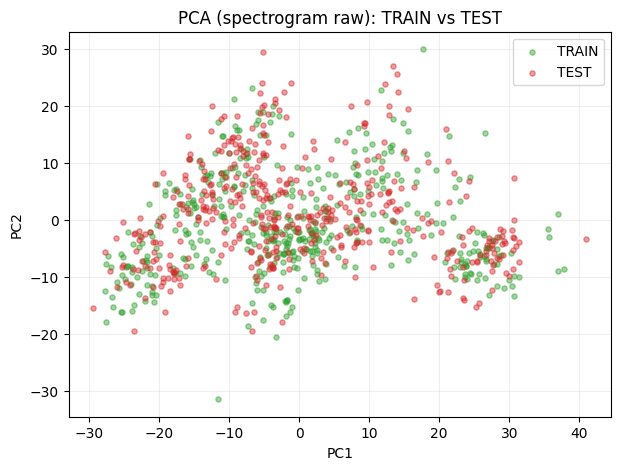


Gợi ý đọc kết quả:
- Nếu TRAIN/TEST tách thành 2 cụm rõ trên PCA + nhiều feature có KS p nhỏ => domain shift (lệch phân phối) là nguyên nhân chính của lệch acc.
- Nếu PCA trộn tốt + KS ít feature lệch nhưng DL vẫn lệch mạnh => có thể do model overfit / input pipeline / augmentation / label noise.


In [21]:
# 5) Kiểm tra lệch phân phối (distribution shift) giữa TRAIN vs TEST
# Mục tiêu: giải thích vì sao train acc cao nhưng test/valid acc thấp dù đã de-dup.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

try:
    from scipy.stats import ks_2samp
except Exception as e:
    ks_2samp = None
    print('SciPy chưa sẵn sàng cho KS-test:', repr(e))


def _topk_mean_shift(Xtr, Xte, feature_names=None, k=15):
    mu_tr = Xtr.mean(axis=0)
    mu_te = Xte.mean(axis=0)
    d = np.abs(mu_tr - mu_te)
    idx = np.argsort(d)[::-1][:k]
    rows = []
    for j in idx:
        rows.append({
            'feature': feature_names[j] if feature_names is not None else f'f{j}',
            'abs_mean_diff': float(d[j]),
            'train_mean': float(mu_tr[j]),
            'test_mean': float(mu_te[j]),
            'train_std': float(Xtr[:, j].std()),
            'test_std': float(Xte[:, j].std()),
        })
    return rows


print('\n=== Distribution shift diagnostics (TRAIN vs TEST) ===')
print('X_bp_train:', X_bp_train.shape, 'X_bp_test:', X_bp_test.shape)
print('X_spec_train:', X_spec_train.shape, 'X_spec_test:', X_spec_test.shape)

# A) Bandpower: thống kê top feature lệch mean nhiều nhất
rows = _topk_mean_shift(X_bp_train, X_bp_test, feature_names=bp_cols_ref, k=12)
print('\n[A] Top feature lệch mean nhiều nhất (bandpower):')
for r in rows:
    print(f"- {r['feature']}: |mean_tr-mean_te|={r['abs_mean_diff']:.4g} | tr_mean={r['train_mean']:.4g} te_mean={r['test_mean']:.4g} | tr_std={r['train_std']:.4g} te_std={r['test_std']:.4g}")

# B) KS-test per feature (nếu có SciPy)
if ks_2samp is not None:
    pvals = []
    for j in range(X_bp_train.shape[1]):
        try:
            p = ks_2samp(X_bp_train[:, j], X_bp_test[:, j]).pvalue
        except Exception:
            p = 1.0
        pvals.append(p)
    pvals = np.asarray(pvals)
    alpha = 0.01
    sig = int((pvals < alpha).sum())
    print(f"\n[B] KS-test (bandpower) alpha={alpha}: số feature lệch phân phối đáng kể = {sig}/{len(pvals)}")
    worst = np.argsort(pvals)[:10]
    print('Top 10 feature có p-value nhỏ nhất:')
    for j in worst:
        name = bp_cols_ref[j] if bp_cols_ref is not None else f'f{j}'
        print(f"- {name}: p={pvals[j]:.3e}")

# C) PCA 2D trên bandpower để nhìn trực quan train/test có bị tách cụm không
scaler = StandardScaler()
X_all = np.vstack([X_bp_train, X_bp_test])
X_all_s = scaler.fit_transform(X_all)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z = pca.fit_transform(X_all_s)
Z_tr = Z[:len(X_bp_train)]
Z_te = Z[len(X_bp_train):]

plt.figure(figsize=(7, 5))
plt.scatter(Z_tr[:, 0], Z_tr[:, 1], s=14, alpha=0.45, label='TRAIN', c='tab:blue')
plt.scatter(Z_te[:, 0], Z_te[:, 1], s=14, alpha=0.45, label='TEST', c='tab:orange')
plt.title('PCA (bandpower): TRAIN vs TEST')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# D) Spectrogram shift (global mean/std + PCA nhẹ trên vector hoá)
# Lưu ý: spectrogram shape (N,F,T,1) khá nhỏ (12x7) nên vector hoá PCA được.
Xsp_tr = X_spec_train.reshape(len(X_spec_train), -1)
Xsp_te = X_spec_test.reshape(len(X_spec_test), -1)

print('\n[C] Spectrogram (raw) stats:')
print('  TRAIN mean/std:', float(Xsp_tr.mean()), float(Xsp_tr.std()))
print('  TEST  mean/std:', float(Xsp_te.mean()), float(Xsp_te.std()))

Xsp_all = np.vstack([Xsp_tr, Xsp_te])
Xsp_all_s = StandardScaler().fit_transform(Xsp_all)
Zs = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xsp_all_s)
Zs_tr = Zs[:len(Xsp_tr)]
Zs_te = Zs[len(Xsp_tr):]

plt.figure(figsize=(7, 5))
plt.scatter(Zs_tr[:, 0], Zs_tr[:, 1], s=14, alpha=0.45, label='TRAIN', c='tab:green')
plt.scatter(Zs_te[:, 0], Zs_te[:, 1], s=14, alpha=0.45, label='TEST', c='tab:red')
plt.title('PCA (spectrogram raw): TRAIN vs TEST')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

print('\nGợi ý đọc kết quả:')
print('- Nếu TRAIN/TEST tách thành 2 cụm rõ trên PCA + nhiều feature có KS p nhỏ => domain shift (lệch phân phối) là nguyên nhân chính của lệch acc.')
print('- Nếu PCA trộn tốt + KS ít feature lệch nhưng DL vẫn lệch mạnh => có thể do model overfit / input pipeline / augmentation / label noise.')


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import numpy as np

# Dùng chung cho tất cả mô hình
if 'results' not in globals() or not isinstance(results, dict):
    results = {}

# Scale bandpower (dùng chung cho LogReg/KNN/ANN)
scaler_bp = RobustScaler()
Xbp_train_s = scaler_bp.fit_transform(X_bp_train)
Xbp_test_s = scaler_bp.transform(X_bp_test)


def evaluate_and_store(name, y_true, y_pred, y_prob=None, model_obj=None, meta=None):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    print(f'===== {name} =====')
    print(classification_report(y_true, y_pred))
    print('Accuracy:', accuracy_score(y_true, y_pred))
    if y_prob is not None:
        y_prob = np.asarray(y_prob).astype(float)
        print('ROC-AUC:', roc_auc_score(y_true, y_prob))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['c (0)', 'a (1)'])
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='d')
    ax.set_title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()

    results[name] = {
        'y_pred': y_pred,
        'y_prob': None if y_prob is None else y_prob,
        'model_obj': model_obj,
        'meta': meta,
    }


print('Ready: Xbp_train_s/Xbp_test_s + evaluate_and_store(...)')


Ready: Xbp_train_s/Xbp_test_s + evaluate_and_store(...)


In [23]:
# Data quality checks (sau khi biến đổi/scale)
import numpy as np
import pandas as pd


def _nan_inf_report(name, X):
    X = np.asarray(X)
    n = X.shape[0]
    nan_count = int(np.isnan(X).sum())
    inf_count = int(np.isinf(X).sum())
    print(f'[{name}] shape={X.shape} | NaN={nan_count} | Inf={inf_count}')
    # tỷ lệ NaN theo feature (nếu là 2D)
    if X.ndim == 2:
        nan_feat = np.isnan(X).mean(axis=0)
        worst = np.argsort(nan_feat)[::-1][:10]
        if nan_feat[worst[0]] > 0:
            print('  Top feature NaN ratio:')
            for j in worst:
                if nan_feat[j] <= 0:
                    break
                print(f'  - f{j}: {nan_feat[j]:.4f}')


def _constant_feature_report(name, X, feature_names=None, eps=1e-12):
    X = np.asarray(X)
    if X.ndim != 2:
        return
    var = X.var(axis=0)
    const_idx = np.where(var <= eps)[0]
    print(f'[{name}] constant/near-constant features: {len(const_idx)}/{X.shape[1]}')
    if len(const_idx) > 0:
        sample = const_idx[:15]
        cols = []
        for j in sample:
            cols.append(feature_names[j] if feature_names is not None else f'f{j}')
        print('  sample:', cols)


def _skew_report(name, X, feature_names=None, topk=12):
    X = np.asarray(X)
    if X.ndim != 2:
        return
    # dùng pandas skew để tránh phụ thuộc SciPy
    df = pd.DataFrame(X)
    sk = df.skew(axis=0, skipna=True).values
    sk_abs = np.abs(sk)
    idx = np.argsort(sk_abs)[::-1][:topk]
    print(f'[{name}] top {topk} feature |skew| lớn nhất:')
    for j in idx:
        fname = feature_names[j] if feature_names is not None else f'f{j}'
        print(f'  - {fname}: skew={sk[j]:.3f}')


def _outlier_report_iqr(name, X, feature_names=None, topk=12, iqr_k=3.0):
    X = np.asarray(X)
    if X.ndim != 2:
        return
    q1 = np.nanpercentile(X, 25, axis=0)
    q3 = np.nanpercentile(X, 75, axis=0)
    iqr = q3 - q1
    lo = q1 - iqr_k * iqr
    hi = q3 + iqr_k * iqr
    out = (X < lo) | (X > hi)
    out_ratio = np.nanmean(out, axis=0)
    idx = np.argsort(out_ratio)[::-1][:topk]
    print(f'[{name}] outlier ratio theo IQR (k={iqr_k}) - top {topk}:')
    for j in idx:
        if out_ratio[j] <= 0:
            break
        fname = feature_names[j] if feature_names is not None else f'f{j}'
        print(f'  - {fname}: outlier_ratio={out_ratio[j]:.4f}')


def _outlier_report_z(name, X, feature_names=None, topk=12, z_thresh=5.0):
    X = np.asarray(X)
    if X.ndim != 2:
        return
    mu = np.nanmean(X, axis=0)
    sd = np.nanstd(X, axis=0) + 1e-12
    z = (X - mu) / sd
    out = np.abs(z) > z_thresh
    out_ratio = np.nanmean(out, axis=0)
    idx = np.argsort(out_ratio)[::-1][:topk]
    print(f'[{name}] outlier ratio theo |z|>{z_thresh} - top {topk}:')
    for j in idx:
        if out_ratio[j] <= 0:
            break
        fname = feature_names[j] if feature_names is not None else f'f{j}'
        print(f'  - {fname}: outlier_ratio={out_ratio[j]:.4f}')


print('=== DATA QUALITY CHECKS (sau khi biến đổi) ===')

# A) Bandpower đã scale
if 'Xbp_train_s' in globals() and 'Xbp_test_s' in globals():
    _nan_inf_report('Xbp_train_s', Xbp_train_s)
    _nan_inf_report('Xbp_test_s', Xbp_test_s)
    _constant_feature_report('Xbp_train_s', Xbp_train_s, feature_names=bp_cols_ref if 'bp_cols_ref' in globals() else None)
    _skew_report('Xbp_train_s', Xbp_train_s, feature_names=bp_cols_ref if 'bp_cols_ref' in globals() else None)
    _outlier_report_iqr('Xbp_train_s', Xbp_train_s, feature_names=bp_cols_ref if 'bp_cols_ref' in globals() else None, iqr_k=3.0)
    _outlier_report_z('Xbp_train_s', Xbp_train_s, feature_names=bp_cols_ref if 'bp_cols_ref' in globals() else None, z_thresh=5.0)

# B) Spectrogram raw (log10) - kiểm tra NaN/Inf + outlier global
if 'X_spec_train' in globals() and 'X_spec_test' in globals():
    Xsp_tr = np.asarray(X_spec_train)
    Xsp_te = np.asarray(X_spec_test)
    _nan_inf_report('X_spec_train', Xsp_tr)
    _nan_inf_report('X_spec_test', Xsp_te)

    # Flatten để kiểm tra outlier theo từng pixel (F*T)
    Xsp_tr_flat = Xsp_tr.reshape(len(Xsp_tr), -1)
    _constant_feature_report('Xsp_train_flat', Xsp_tr_flat)
    _outlier_report_z('Xsp_train_flat', Xsp_tr_flat, topk=10, z_thresh=6.0)

print('=== END DATA QUALITY CHECKS ===')


=== DATA QUALITY CHECKS (sau khi biến đổi) ===
[Xbp_train_s] shape=(468, 320) | NaN=0 | Inf=0
[Xbp_test_s] shape=(456, 320) | NaN=0 | Inf=0
[Xbp_train_s] constant/near-constant features: 0/320
[Xbp_train_s] top 12 feature |skew| lớn nhất:
  - bp_beta_AF8: skew=18.512
  - bp_beta_F6: skew=16.908
  - bp_gamma_AF8: skew=15.155
  - bp_gamma_FC3: skew=12.471
  - bp_gamma_F6: skew=11.644
  - bp_delta_Y: skew=9.205
  - bp_theta_C4: skew=8.589
  - bp_delta_AF8: skew=7.137
  - bp_beta_AF1: skew=6.893
  - bp_beta_C4: skew=6.865
  - bp_theta_C6: skew=6.837
  - bp_delta_X: skew=6.832
[Xbp_train_s] outlier ratio theo IQR (k=3.0) - top 12:
  - bp_delta_X: outlier_ratio=0.1175
  - bp_gamma_FC6: outlier_ratio=0.1154
  - bp_gamma_TP7: outlier_ratio=0.1154
  - bp_gamma_F8: outlier_ratio=0.1111
  - bp_delta_FP1: outlier_ratio=0.1026
  - bp_delta_nd: outlier_ratio=0.1004
  - bp_gamma_T8: outlier_ratio=0.0983
  - bp_gamma_FC4: outlier_ratio=0.0962
  - bp_delta_FP2: outlier_ratio=0.0919
  - bp_theta_X: outl

In [24]:
# Model: Logistic Regression (Bandpower)
from sklearn.linear_model import LogisticRegression

lr_bp = LogisticRegression(random_state=RANDOM_STATE, max_iter=5000, solver='liblinear')
lr_bp.fit(Xbp_train_s, y_train)

y_pred_lr = lr_bp.predict(Xbp_test_s)
y_prob_lr = lr_bp.predict_proba(Xbp_test_s)[:, 1]


===== Logistic Regression (Bandpower) =====
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       223
           1       0.98      0.98      0.98       233

    accuracy                           0.98       456
   macro avg       0.98      0.98      0.98       456
weighted avg       0.98      0.98      0.98       456

Accuracy: 0.9780701754385965


ROC-AUC: 0.9884716795935256


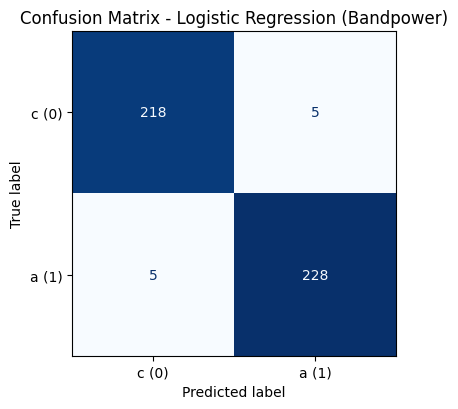

In [ ]:
# Đánh giá: Logistic Regression (Bandpower)
evaluate_and_store('Logistic Regression (Bandpower)', y_test, y_pred_lr, y_prob_lr, model_obj=lr_bp, meta={'type': 'sklearn'})


In [26]:
# Model: Random Forest (Bandpower)
from sklearn.ensemble import RandomForestClassifier

rf_bp = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf_bp.fit(X_bp_train, y_train)

y_pred_rf = rf_bp.predict(X_bp_test)
y_prob_rf = rf_bp.predict_proba(X_bp_test)[:, 1]


===== Random Forest (Bandpower) =====
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       223
           1       0.98      0.91      0.95       233

    accuracy                           0.95       456
   macro avg       0.95      0.95      0.95       456
weighted avg       0.95      0.95      0.95       456

Accuracy: 0.9473684210526315
ROC-AUC: 0.9901460767143324


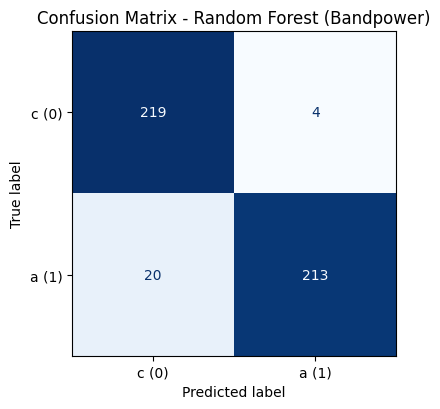

In [ ]:
# Đánh giá: Random Forest (Bandpower)
if 'y_pred_rf' in globals():
    evaluate_and_store('Random Forest (Bandpower)', y_test, y_pred_rf, y_prob_rf, model_obj=rf_bp, meta={'type': 'sklearn'})


In [28]:
# Model: XGBoost (Bandpower)
try:
    from xgboost import XGBClassifier

    xgb_bp = XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
    )
    xgb_bp.fit(X_bp_train, y_train)

    y_pred_xgb = xgb_bp.predict(X_bp_test)
    y_prob_xgb = xgb_bp.predict_proba(X_bp_test)[:, 1]
except Exception as e:
    print('XGBoost chưa sẵn sàng trong môi trường này:', repr(e))


===== XGBoost (Bandpower) =====
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       223
           1       0.98      0.96      0.97       233

    accuracy                           0.97       456
   macro avg       0.97      0.97      0.97       456
weighted avg       0.97      0.97      0.97       456

Accuracy: 0.9692982456140351
ROC-AUC: 0.996747435477973


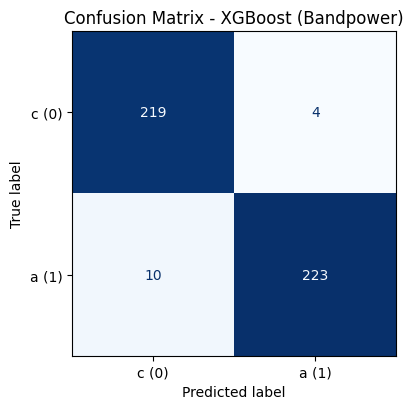

In [ ]:
# Đánh giá: XGBoost (Bandpower)
if 'y_pred_xgb' in globals():
    evaluate_and_store('XGBoost (Bandpower)', y_test, y_pred_xgb, y_prob_xgb, model_obj=xgb_bp, meta={'type': 'xgboost'})


In [30]:
# Model: KNN (Bandpower)
from sklearn.neighbors import KNeighborsClassifier

knn_bp = KNeighborsClassifier(n_neighbors=7)
knn_bp.fit(Xbp_train_s, y_train)

y_pred_knn = knn_bp.predict(Xbp_test_s)
y_prob_knn = knn_bp.predict_proba(Xbp_test_s)[:, 1]


===== KNN (Bandpower) =====
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       223
           1       0.90      0.96      0.93       233

    accuracy                           0.92       456
   macro avg       0.93      0.92      0.92       456
weighted avg       0.93      0.92      0.92       456

Accuracy: 0.9232456140350878
ROC-AUC: 0.9855655420620104


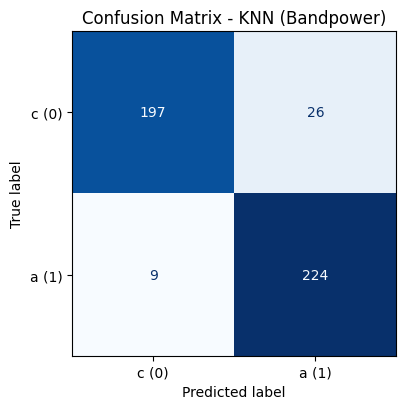

In [ ]:
# Đánh giá: KNN (Bandpower)
if 'y_pred_knn' in globals():
    evaluate_and_store('KNN (Bandpower)', y_test, y_pred_knn, y_prob_knn, model_obj=knn_bp, meta={'type': 'sklearn'})


In [32]:
# Model: ANN/MLP (Bandpower)
from sklearn.neural_network import MLPClassifier

mlp_bp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=64,
    learning_rate_init=1e-3,
    max_iter=300,
    random_state=RANDOM_STATE,
)

mlp_bp.fit(Xbp_train_s, y_train)

y_pred_mlp = mlp_bp.predict(Xbp_test_s)
# MLPClassifier có predict_proba
try:
    y_prob_mlp = mlp_bp.predict_proba(Xbp_test_s)[:, 1]
except Exception:
    y_prob_mlp = None


===== ANN/MLP (Bandpower) =====
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       223
           1       0.98      0.97      0.98       233

    accuracy                           0.98       456
   macro avg       0.98      0.98      0.98       456
weighted avg       0.98      0.98      0.98       456

Accuracy: 0.9780701754385965
ROC-AUC: 0.9946688735349026


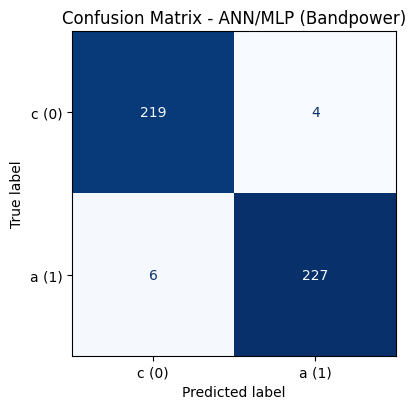

In [ ]:
# Đánh giá: ANN/MLP (Bandpower)
evaluate_and_store('ANN/MLP (Bandpower)', y_test, y_pred_mlp, y_prob_mlp, model_obj=mlp_bp, meta={'type': 'sklearn'})


In [34]:
# Sanity check: ANN/MLP có "học vẹt" / overfit không?
# - Nếu train acc/auc ~1.0 nhưng test thấp nhiều => overfit
# - Nếu shuffle label mà test vẫn cao => khả năng leak/bug pipeline

from sklearn.metrics import accuracy_score
try:
    from sklearn.metrics import roc_auc_score
except Exception:
    roc_auc_score = None

# 1) Train vs Test metrics cho ANN/MLP (MLPClassifier)
if 'mlp_bp' in globals():
    y_pred_tr = mlp_bp.predict(Xbp_train_s)
    try:
        y_prob_tr = mlp_bp.predict_proba(Xbp_train_s)[:, 1]
    except Exception:
        y_prob_tr = None

    tr_acc = accuracy_score(y_train, y_pred_tr)
    te_acc = accuracy_score(y_test, y_pred_mlp)

    print('=== ANN/MLP sanity: Train vs Test ===')
    print('Train acc:', tr_acc)
    print('Test  acc:', te_acc)

    if roc_auc_score is not None and y_prob_tr is not None and 'y_prob_mlp' in globals():
        try:
            tr_auc = roc_auc_score(y_train, y_prob_tr)
            te_auc = roc_auc_score(y_test, y_prob_mlp)
            print('Train AUC:', tr_auc)
            print('Test  AUC:', te_auc)
        except Exception as e:
            print('Không tính được AUC:', repr(e))

# 2) Shuffle-label test (sanity)
# Kỳ vọng: test acc ~0.5 (nhị phân) nếu không có leak/bug
from sklearn.neural_network import MLPClassifier

rng = np.random.default_rng(RANDOM_STATE)
y_train_shuf = rng.permutation(y_train)

mlp_shuf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=32,
    learning_rate_init=1e-3,
    max_iter=200,
    random_state=RANDOM_STATE,
)

mlp_shuf.fit(Xbp_train_s, y_train_shuf)
y_pred_shuf = mlp_shuf.predict(Xbp_test_s)
acc_shuf = accuracy_score(y_test, y_pred_shuf)

print('\n=== Shuffle-label sanity check (ANN/MLP) ===')
print('Test acc (train labels shuffled):', acc_shuf)

if roc_auc_score is not None:
    try:
        y_prob_shuf = mlp_shuf.predict_proba(Xbp_test_s)[:, 1]
        auc_shuf = roc_auc_score(y_test, y_prob_shuf)
        print('Test AUC (train labels shuffled):', auc_shuf)
    except Exception:
        pass


=== ANN/MLP sanity: Train vs Test ===
Train acc: 1.0
Test  acc: 0.9780701754385965
Train AUC: 1.0
Test  AUC: 0.9946688735349026

=== Shuffle-label sanity check (ANN/MLP) ===
Test acc (train labels shuffled): 0.4780701754385965
Test AUC (train labels shuffled): 0.45841913816663143


In [ ]:
# Đánh giá: Small CNN (Spectrogram)
if 'y_pred_cnn' in globals():
    model_obj = model_cnn if 'model_cnn' in globals() else None
    evaluate_and_store('Small CNN (Spectrogram)', y_test, y_pred_cnn, y_prob_cnn, model_obj=model_obj, meta={'type': 'keras'})


In [36]:
import numpy as np

# Deep learning: Small CNN trên spectrogram
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    tf.random.set_seed(RANDOM_STATE)

    Xtr = X_spec_train.astype(np.float32)
    Xte = X_spec_test.astype(np.float32)

    mu = float(Xtr.mean())
    sd = float(Xtr.std())
    Xtr_n = (Xtr - mu) / (sd + 1e-6)
    Xte_n = (Xte - mu) / (sd + 1e-6)

    print('Spectrogram normalized:', Xtr_n.shape, Xte_n.shape)

    model_cnn = keras.Sequential([
        layers.Input(shape=Xtr_n.shape[1:]),
        layers.Conv2D(16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.35),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.35),

        layers.Dense(1, activation='sigmoid'),
    ])

    model_cnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), keras.metrics.BinaryAccuracy(name='acc')],
    )

    cb = [
        keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True)
    ]

    hist_cnn = model_cnn.fit(
        Xtr_n, y_train,
        validation_data=(Xte_n, y_test),
        epochs=60,
        batch_size=32,
        callbacks=cb,
        verbose=1,
    )

    y_prob_cnn = model_cnn.predict(Xte_n).ravel()
    y_pred_cnn = (y_prob_cnn >= 0.5).astype(int)

except Exception as e:
    print('TensorFlow/Keras chưa sẵn sàng trong môi trường này:', repr(e))


Spectrogram normalized: (468, 46, 13, 1) (456, 46, 13, 1)
Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - acc: 0.5897 - auc: 0.6412 - loss: 0.7354 - val_acc: 0.4912 - val_auc: 0.7449 - val_loss: 0.6848
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.6325 - auc: 0.6942 - loss: 0.6819 - val_acc: 0.6952 - val_auc: 0.7575 - val_loss: 0.6684
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.6987 - auc: 0.7580 - loss: 0.6152 - val_acc: 0.7215 - val_auc: 0.7721 - val_loss: 0.6547
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.6859 - auc: 0.7445 - loss: 0.6248 - val_acc: 0.6118 - val_auc: 0.7783 - val_loss: 0.6468
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.6880 - auc: 0.7634 - loss: 0.5912 - val_acc: 0.5702 - val_auc: 0.7804 - val_loss: 0.6430
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.6859 - auc: 0.7592 - loss: 0.5970 - val_acc: 0.5658 - val_auc: 0.7866 - val_loss: 0.6360
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/st

In [37]:
# Deep learning (Transfer Learning): EfficientNetB0 (ImageNet) trên spectrogram
# Lưu ý quan trọng:
# - EfficientNet pretrained ImageNet kỳ vọng input là ảnh RGB; tốt nhất đưa về scale ảnh (0..255) rồi dùng preprocess_input.
# - Nếu z-score rồi lại preprocess_input, model dễ bị "mù" => accuracy/AUC rất thấp.

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    tf.random.set_seed(RANDOM_STATE)

    # Chuẩn hoá kiểu ảnh: min-max theo TRAIN -> [0, 255]
    Xtr = X_spec_train.astype(np.float32)
    Xte = X_spec_test.astype(np.float32)

    vmin = float(Xtr.min())
    vmax = float(Xtr.max())
    if vmax <= vmin:
        raise ValueError('Spectrogram train có vmax<=vmin, không thể min-max scale.')

    Xtr_01 = (Xtr - vmin) / (vmax - vmin + 1e-6)
    Xte_01 = (Xte - vmin) / (vmax - vmin + 1e-6)

    Xtr_255 = Xtr_01 * 255.0
    Xte_255 = Xte_01 * 255.0

    # Convert (N,F,T,1) -> (N,224,224,3)
    def _prep_for_imagenet(X_255):
        X = tf.convert_to_tensor(X_255, dtype=tf.float32)
        X = tf.image.resize(X, (224, 224), method='bilinear')
        X = tf.repeat(X, repeats=3, axis=-1)
        return X

    Xtr_img = _prep_for_imagenet(Xtr_255)
    Xte_img = _prep_for_imagenet(Xte_255)

    print('Transfer input:', Xtr_img.shape, Xte_img.shape)

    base = keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
    )
    base.trainable = False

    inp = keras.Input(shape=(224, 224, 3))
    x = keras.applications.efficientnet.preprocess_input(inp)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model_tl = keras.Model(inp, out, name='EfficientNetB0_TL')

    model_tl.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), keras.metrics.BinaryAccuracy(name='acc')],
    )

    cb = [
        keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=True)
    ]

    # Phase 1: train head
    hist_tl_1 = model_tl.fit(
        Xtr_img, y_train,
        validation_data=(Xte_img, y_test),
        epochs=25,
        batch_size=16,
        callbacks=cb,
        verbose=1,
    )

    # Phase 2: fine-tune nhẹ (mở một phần backbone)
    base.trainable = True
    for layer in base.layers[:-30]:
        layer.trainable = False

    model_tl.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), keras.metrics.BinaryAccuracy(name='acc')],
    )

    hist_tl_2 = model_tl.fit(
        Xtr_img, y_train,
        validation_data=(Xte_img, y_test),
        epochs=15,
        batch_size=16,
        callbacks=cb,
        verbose=1,
    )

    y_prob_tl = model_tl.predict(Xte_img).ravel()
    y_pred_tl = (y_prob_tl >= 0.5).astype(int)

except Exception as e:
    print('TensorFlow/Keras chưa sẵn sàng hoặc không load được pretrained weights:', repr(e))


Transfer input: (468, 224, 224, 3) (456, 224, 224, 3)
Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 560ms/step - acc: 0.5299 - auc: 0.5301 - loss: 0.7027 - val_acc: 0.6250 - val_auc: 0.6833 - val_loss: 0.6716
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 504ms/step - acc: 0.5769 - auc: 0.6208 - loss: 0.6688 - val_acc: 0.6557 - val_auc: 0.7521 - val_loss: 0.6442
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 561ms/step - acc: 0.6132 - auc: 0.6604 - loss: 0.6498 - val_acc: 0.6842 - val_auc: 0.7927 - val_loss: 0.6222
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 521ms/step - acc: 0.6303 - auc: 0.6851 - loss: 0.6341 - val_acc: 0.7039 - val_auc: 0.8180 - val_loss: 0.6065
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 519ms/step - acc: 0.6389 - auc: 0.6947 - loss: 0.6279 - val_acc: 0.7039 - val_auc: 0.8464 - val_loss: 0.5959
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 568ms/step - acc: 0.6496 - auc: 0.7207 - loss: 0.6150 - val_acc: 0.7259 - val_auc: 0.8557 - val_loss: 0.5846
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 15

===== EfficientNetB0 TL (Spectrogram) =====
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       223
           1       0.86      0.80      0.83       233

    accuracy                           0.83       456
   macro avg       0.83      0.83      0.83       456
weighted avg       0.83      0.83      0.83       456

Accuracy: 0.831140350877193
ROC-AUC: 0.8932812409784637


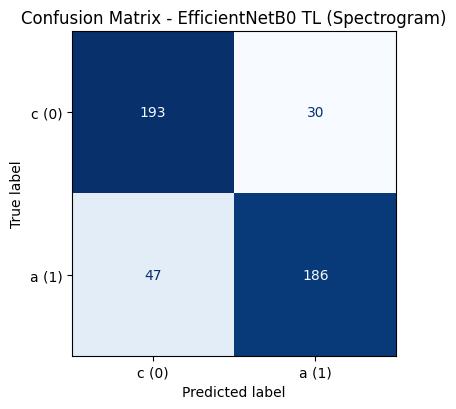

In [ ]:
# Đánh giá: EfficientNetB0 Transfer Learning (Spectrogram)
if 'y_pred_tl' in globals():
    model_obj = model_tl if 'model_tl' in globals() else None
    evaluate_and_store('EfficientNetB0 TL (Spectrogram)', y_test, y_pred_tl, y_prob_tl, model_obj=model_obj, meta={'type': 'keras'})


In [ ]:
# Export models: lưu model tốt nhất và/hoặc tất cả model đã evaluate
import os

SAVE_DIR = 'saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

# Lưu scaler cho bandpower để inference sau này
try:
    import joblib
    joblib.dump(scaler_bp, os.path.join(SAVE_DIR, 'scaler_bp.joblib'))
    print('Saved scaler:', os.path.join(SAVE_DIR, 'scaler_bp.joblib'))
except Exception as e:
    print('Không lưu được scaler_bp:', repr(e))


def _safe_filename(name: str) -> str:
    bad = ['/', '\\', ':', '*', '?', '"', '<', '>', '|']
    s = name
    for b in bad:
        s = s.replace(b, '_')
    return s


def save_model_artifact(name, model_obj, meta=None):
    if model_obj is None:
        print(f'Skip {name}: model_obj=None')
        return None

    meta = meta or {}
    fbase = _safe_filename(name)

    # Keras model
    if hasattr(model_obj, 'save') and meta.get('type') == 'keras':
        out_path = os.path.join(SAVE_DIR, f'{fbase}.keras')
        try:
            model_obj.save(out_path)
            print('Saved keras model:', out_path)
            return out_path
        except Exception as e:
            print(f'Không lưu được keras model {name}:', repr(e))
            return None

    # Sklearn / xgboost
    try:
        import joblib
        out_path = os.path.join(SAVE_DIR, f'{fbase}.joblib')
        joblib.dump(model_obj, out_path)
        print('Saved model:', out_path)
        return out_path
    except Exception as e:
        print(f'Không lưu được model {name}:', repr(e))
        return None


print('\n=== Export all evaluated models ===')
saved_paths = {}
for name, info in results.items():
    saved_paths[name] = save_model_artifact(name, info.get('model_obj'), meta=info.get('meta'))

# Nếu có metrics_df thì chọn best overall
if 'metrics_df' in globals() and metrics_df is not None and len(metrics_df) > 0:
    # Ưu tiên roc_auc (nếu có), fallback accuracy
    cols = list(metrics_df.columns)
    sort_cols = []
    if 'roc_auc' in cols:
        sort_cols.append('roc_auc')
    if 'accuracy' in cols:
        sort_cols.append('accuracy')

    best_row = metrics_df.sort_values(sort_cols, ascending=False).iloc[0]
    best_name = str(best_row['model'])
    print('\nBest overall:', best_name)

    if best_name in results:
        best_path = save_model_artifact('BEST__' + best_name, results[best_name].get('model_obj'), meta=results[best_name].get('meta'))
        saved_paths['BEST__' + best_name] = best_path

print('\nDone export. Saved files in:', os.path.abspath(SAVE_DIR))


ANN/MLP (Bandpower) - Accuracy: 0.9780701754385965


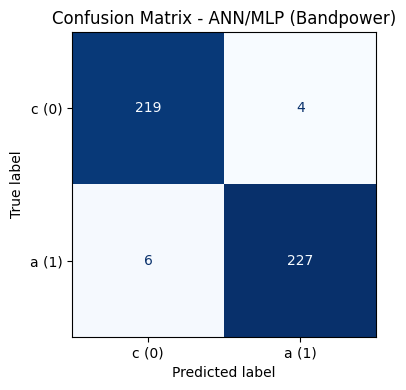

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

if 'y_pred_mlp' not in globals():
    raise NameError('Chưa có y_pred_mlp. Hãy chạy cell ANN/MLP trước.')

cm = confusion_matrix(y_test, y_pred_mlp, labels=[0, 1])
acc = accuracy_score(y_test, y_pred_mlp)

print('ANN/MLP (Bandpower) - Accuracy:', acc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['c (0)', 'a (1)'])
fig, ax = plt.subplots(figsize=(4.5, 4))
disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='d')
ax.set_title('Confusion Matrix - ANN/MLP (Bandpower)')
plt.tight_layout()
plt.show()

In [40]:
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

# Sanity check: GroupKFold CV chỉ trên TRAIN (SMNI_CMI_TRAIN)
# Lưu ý: không nên dùng SMNI_CMI_TEST cho tuning, chỉ dùng để đánh giá cuối.

cv = GroupKFold(n_splits=5)

lr_cv = make_pipeline(
    RobustScaler(),
    LogisticRegression(max_iter=5000, solver='liblinear', random_state=RANDOM_STATE),
)

accs = []
aucs = []
for fold, (tr, te) in enumerate(cv.split(X_bp_train, y_train, groups=groups_train), start=1):
    lr_cv.fit(X_bp_train[tr], y_train[tr])
    pred = lr_cv.predict(X_bp_train[te])
    prob = lr_cv.predict_proba(X_bp_train[te])[:, 1]
    acc = (pred == y_train[te]).mean()
    auc = roc_auc_score(y_train[te], prob)
    accs.append(acc)
    aucs.append(auc)
    print(f'Fold {fold}: acc={acc:.4f} auc={auc:.4f}')

print('GroupKFold (TRAIN) LogisticRegression:')
print('  acc mean±std:', float(np.mean(accs)), float(np.std(accs)))
print('  auc mean±std:', float(np.mean(aucs)), float(np.std(aucs)))

# Permutation test trên TRAIN
rng = np.random.default_rng(RANDOM_STATE)
perm_accs = []
for r in range(3):
    y_perm = y_train.copy()
    rng.shuffle(y_perm)

    accs_perm = []
    for tr, te in cv.split(X_bp_train, y_perm, groups=groups_train):
        lr_cv.fit(X_bp_train[tr], y_perm[tr])
        pred = lr_cv.predict(X_bp_train[te])
        accs_perm.append((pred == y_perm[te]).mean())

    perm_accs.append(float(np.mean(accs_perm)))

print('Permutation test (TRAIN mean CV acc over 3 runs):', perm_accs)


Fold 1: acc=1.0000 auc=1.0000
Fold 2: acc=0.9787 auc=0.9937
Fold 3: acc=0.9787 auc=0.9986
Fold 4: acc=0.9892 auc=0.9894
Fold 5: acc=1.0000 auc=1.0000
GroupKFold (TRAIN) LogisticRegression:
  acc mean±std: 0.989338824067719 0.009515292897174584
  auc mean±std: 0.9963324853530683 0.004194498018339785
Permutation test (TRAIN mean CV acc over 3 runs): [0.4876229695721803, 0.4723175474719744, 0.5235644017387325]


# 4. Đánh giá mô hình

Phần này tổng hợp metric và trực quan hoá kết quả dự đoán của các mô hình:
- Confusion matrix
- ROC-AUC / Accuracy
- Chọn mô hình tốt nhất trên tập test


In [41]:
print("\nKiểm tra số lượng mẫu sau khi lọc:")
print(f"  - Số file train: {len(train_use)}")
print(f"  - Số file test ban đầu: {len(raw_test_use)}")
print(f"  - Số file test sau lọc: {len(test_use)}")
print(f"  - Số file bị loại (trùng nội dung): {len(dropped_test)}")
print(f"  - Kích thước y_test: {len(y_test) if 'y_test' in globals() else 'Chưa tạo'}")


Kiểm tra số lượng mẫu sau khi lọc:
  - Số file train: 468
  - Số file test ban đầu: 480
  - Số file test sau lọc: 456
  - Số file bị loại (trùng nội dung): 24
  - Kích thước y_test: 456


In [42]:
# (ĐÃ CHUYỂN) Tổng hợp model đã được làm bằng `metrics_df` dựa trên `results` ở phần trên.
# Cell này giữ trống để tránh ghi đè `results`.


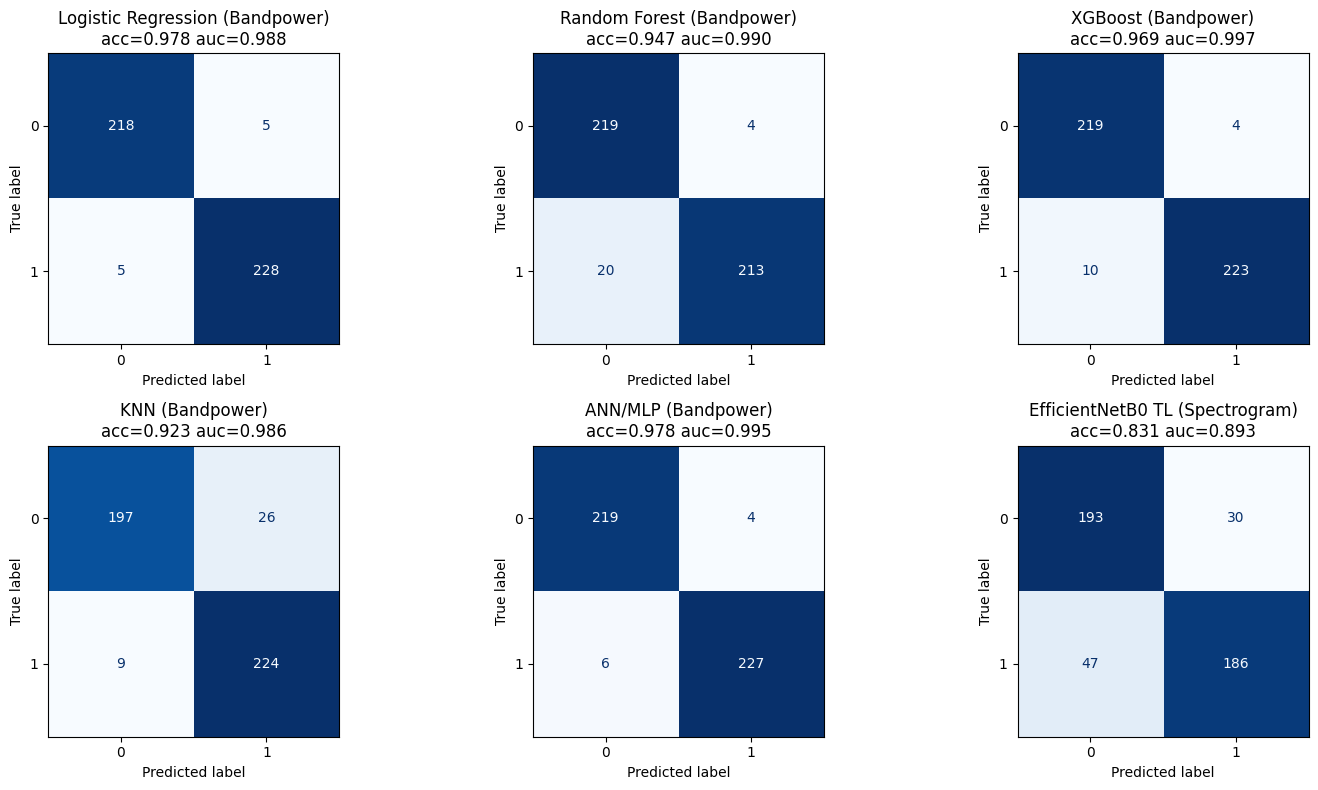

In [43]:
# Confusion matrices
n = len(results)
if n == 0:
    raise ValueError('Chưa có dự đoán nào trong results. Hãy chạy các cell train/eval model trước.')

ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).reshape(-1)

for ax, (name, r) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, r['y_pred'], labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    acc = accuracy_score(y_test, r['y_pred'])
    title = f'{name}\nacc={acc:.3f}'
    if r['y_prob'] is not None:
        title += f' auc={roc_auc_score(y_test, r["y_prob"]):.3f}'
    ax.set_title(title)

for ax in axes[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# 5. Trích xuất ngược dữ liệu (trace back)

Mục tiêu:
- Chọn mô hình tốt nhất trên test
- Liệt kê các mẫu dự đoán sai kèm `source_file`
- Từ `source_file` load lại dữ liệu gốc và trực quan hoá (spectrogram/bandpower)


In [44]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

try:
    from sklearn.metrics import roc_auc_score
except Exception:
    roc_auc_score = None


def _build_metrics_df_from_results(results_dict, y_true):
    rows = []
    for name, r in results_dict.items():
        if r is None:
            continue
        if 'y_pred' not in r:
            continue
        y_pred = np.asarray(r['y_pred']).astype(int)
        acc = accuracy_score(y_true, y_pred)

        auc = np.nan
        if roc_auc_score is not None and r.get('y_prob') is not None:
            try:
                y_prob = np.asarray(r['y_prob']).astype(float)
                auc = roc_auc_score(y_true, y_prob)
            except Exception:
                auc = np.nan

        rows.append({'model': name, 'accuracy': float(acc), 'roc_auc': float(auc) if np.isfinite(auc) else np.nan})

    if len(rows) == 0:
        return pd.DataFrame(columns=['model', 'accuracy', 'roc_auc'])

    return pd.DataFrame(rows)


# Choose best model (prefer roc_auc if available)
if 'results' not in globals() or not isinstance(results, dict) or len(results) == 0:
    raise ValueError('Chưa có results. Hãy chạy phần đánh giá mô hình (evaluate_and_store) trước.')

if 'y_test' not in globals() or y_test is None or len(y_test) == 0:
    raise ValueError('Chưa có y_test. Hãy chạy phần build dataset trước.')

if 'metrics_df' not in globals() or metrics_df is None or len(metrics_df) == 0:
    metrics_df = _build_metrics_df_from_results(results, y_test)

if metrics_df is None or len(metrics_df) == 0:
    raise ValueError('Không tạo được metrics_df từ results. Hãy chắc rằng bạn đã chạy các cell đánh giá để có y_pred/y_prob.')

_df_auc = metrics_df.dropna(subset=['roc_auc'])
if len(_df_auc) > 0:
    metrics_df = metrics_df.sort_values(['roc_auc', 'accuracy'], ascending=False)
else:
    metrics_df = metrics_df.sort_values(['accuracy'], ascending=False)

best_model_name = str(metrics_df.iloc[0]['model'])
best = results[best_model_name]

print('Best model:', best_model_name)

# Align to TEST set order (SMNI_CMI_TEST)
sf_test = groups_test

# Build trace dataframe
trace_df = pd.DataFrame({
    'source_file': sf_test,
    'y_true': y_test,
    'y_pred': best['y_pred'],
})

if best.get('y_prob') is not None:
    trace_df['y_prob'] = best['y_prob']
    trace_df['confidence'] = np.where(trace_df['y_pred'] == 1, trace_df['y_prob'], 1 - trace_df['y_prob'])
else:
    trace_df['y_prob'] = np.nan
    trace_df['confidence'] = np.nan

trace_df['correct'] = (trace_df['y_true'] == trace_df['y_pred'])

# Wrong predictions sorted by confidence (if prob available)
trace_df_wrong = trace_df[~trace_df['correct']].copy()
if 'confidence' in trace_df_wrong.columns:
    trace_df_wrong = trace_df_wrong.sort_values(['confidence'], ascending=False)

print('n_test:', len(trace_df), '| n_wrong:', len(trace_df_wrong))
display(trace_df_wrong.head(10))


Best model: XGBoost (Bandpower)
n_test: 456 | n_wrong: 14


,source_file,y_true,y_pred,y_prob,confidence,correct
127,Data213.csv,1,0,0.048513,0.951487,False
22,Data119.csv,1,0,0.054090,0.945910,False
141,Data226.csv,1,0,0.172357,0.827643,False
366,Data444.csv,0,1,0.800902,0.800902,False
135,Data220.csv,1,0,0.225086,0.774914,False
166,Data249.csv,0,1,0.769418,0.769418,False
19,Data116.csv,1,0,0.263527,0.736473,False
367,Data445.csv,0,1,0.670888,0.670888,False
154,Data238.csv,1,0,0.332338,0.667662,False
24,Data120.csv,1,0,0.348385,0.651615,False


Trace-back example (most confident wrong): Data213.csv


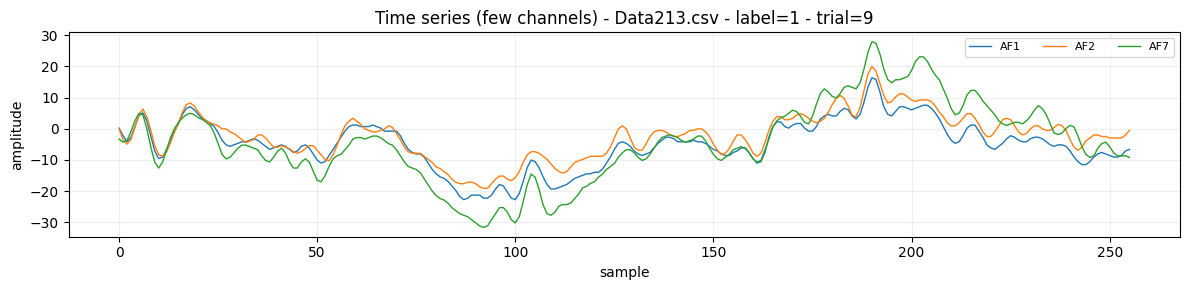

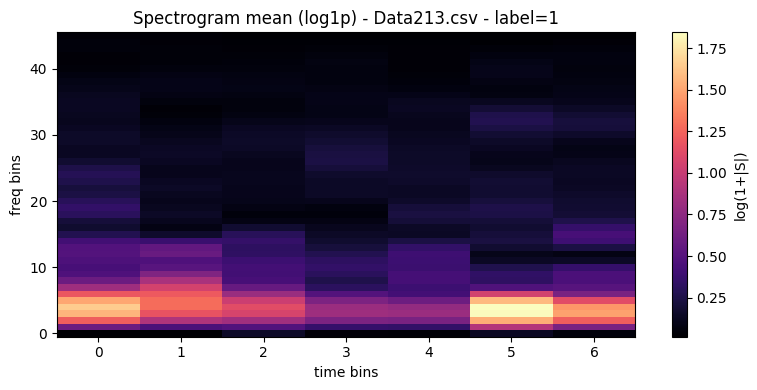

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def _find_file_path_by_basename(basename: str):
    # Search in known file lists
    for fp in (train_files if 'train_files' in globals() else []):
        if os.path.basename(fp) == basename:
            return fp
    for fp in (test_files if 'test_files' in globals() else []):
        if os.path.basename(fp) == basename:
            return fp
    return None


def trace_back_one(source_file: str, fmax=45):
    """Load raw csv by `source_file` (basename like Data123.csv), rebuild epoch matrix and plot."""
    fp = _find_file_path_by_basename(source_file)
    if fp is None:
        raise FileNotFoundError(f'Không tìm thấy {source_file} trong train_files/test_files')

    df_raw = pd.read_csv(fp)
    df_raw['source_file'] = os.path.basename(fp)
    df_long = normalize_long_df(df_raw)

    trial_number = int(df_long['trial_number'].iloc[0])
    label = int(df_long['label'].iloc[0])

    x_ch_t, ch_names = build_epoch_matrix_from_long(df_long, trial_number=trial_number)

    # Plot time series of a few channels
    plt.figure(figsize=(12, 3))
    for i in range(min(3, x_ch_t.shape[0])):
        plt.plot(x_ch_t[i], linewidth=1, label=ch_names[i])
    plt.title(f'Time series (few channels) - {source_file} - label={label} - trial={trial_number}')
    plt.xlabel('sample')
    plt.ylabel('amplitude')
    plt.grid(alpha=0.2)
    plt.legend(ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()

    # Plot spectrogram mean across channels
    f, t, S = spectrogram_tf(x_ch_t, fs=FS, nperseg=64, noverlap=32, fmax=fmax)
    S_img = np.log1p(S).mean(axis=0)  # (F,T)

    plt.figure(figsize=(8, 4))
    plt.imshow(S_img, aspect='auto', origin='lower', cmap='magma')
    plt.title(f'Spectrogram mean (log1p) - {source_file} - label={label}')
    plt.xlabel('time bins')
    plt.ylabel('freq bins')
    plt.colorbar(label='log(1+|S|)')
    plt.tight_layout()
    plt.show()

    return {
        'file_path': fp,
        'label': label,
        'trial_number': trial_number,
        'channels': ch_names,
        'x_ch_t': x_ch_t,
        'spec_img': S_img,
    }


# Example: trace the most confident wrong prediction (if any)
if 'trace_df_wrong' in globals() and trace_df_wrong is not None and len(trace_df_wrong) > 0:
    example_file = str(trace_df_wrong.iloc[0]['source_file'])
    print('Trace-back example (most confident wrong):', example_file)
    _ = trace_back_one(example_file)
else:
    print('Không có mẫu dự đoán sai (hoặc chưa chạy trace_df_wrong). Bạn có thể gọi: trace_back_one("Data123.csv")')


## Trực quan hoá & trích xuất feature (dễ nhìn)

Phần này trực quan hoá dữ liệu theo miền tần số/time-frequency để nhìn rõ khác biệt giữa 2 nhãn.

- Bandpower theo dải tần (delta/theta/alpha/beta/gamma)
- Heatmap chênh lệch theo kênh (channel)
- Spectrogram trung bình theo nhãn và ảnh chênh lệch
- PCA 2D trên feature miền tần số


In [46]:
# Dựng DataFrame feature bandpower để dễ trực quan hóa
# X_bp: (N, n_bands * n_channels) với schema trong bp_cols_ref

if 'bp_cols_ref' not in globals() or bp_cols_ref is None:
    raise ValueError('Chưa có bp_cols_ref. Hãy chạy cell build dataset (tạo X_bp) trước.')

bp_df = pd.DataFrame(X_bp, columns=bp_cols_ref)
bp_df['label'] = y
bp_df['source_file'] = groups

# gom theo band: trung bình qua tất cả channels để nhìn tổng quan
band_cols = {b: [c for c in bp_cols_ref if c.startswith(f'bp_{b}_')] for b in BANDS.keys()}
for b, cols in band_cols.items():
    bp_df[f'bandmean_{b}'] = bp_df[cols].mean(axis=1)

bp_df[['label'] + [f'bandmean_{b}' for b in BANDS.keys()]].head()

,label,bandmean_delta,bandmean_theta,bandmean_alpha,bandmean_beta,bandmean_gamma
0,1,3.585406,2.804906,1.635142,9.742800,10.024077
1,1,3.609715,2.677737,0.783353,8.047700,6.042328
2,1,3.366398,4.174784,8.476105,2.953638,0.727800
3,1,5.510197,14.925726,26.367527,4.243858,0.689156
4,1,3.321755,6.083749,5.592424,2.171558,0.747603


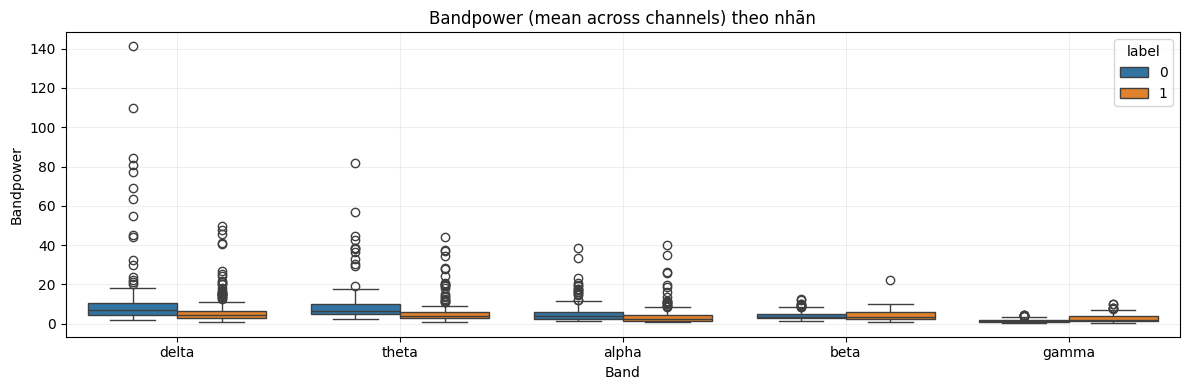

In [47]:
import seaborn as sns

# Boxplot bandpower (mean qua channels) theo label
plot_cols = [f'bandmean_{b}' for b in BANDS.keys()]
plt.figure(figsize=(12, 4))
long_plot = bp_df.melt(id_vars=['label'], value_vars=plot_cols, var_name='band', value_name='bandpower')
long_plot['band'] = long_plot['band'].str.replace('bandmean_', '', regex=False)

sns.boxplot(data=long_plot, x='band', y='bandpower', hue='label')
plt.title('Bandpower (mean across channels) theo nhãn')
plt.xlabel('Band')
plt.ylabel('Bandpower')
plt.grid(alpha=0.2)
plt.legend(title='label')
plt.tight_layout()
plt.show()

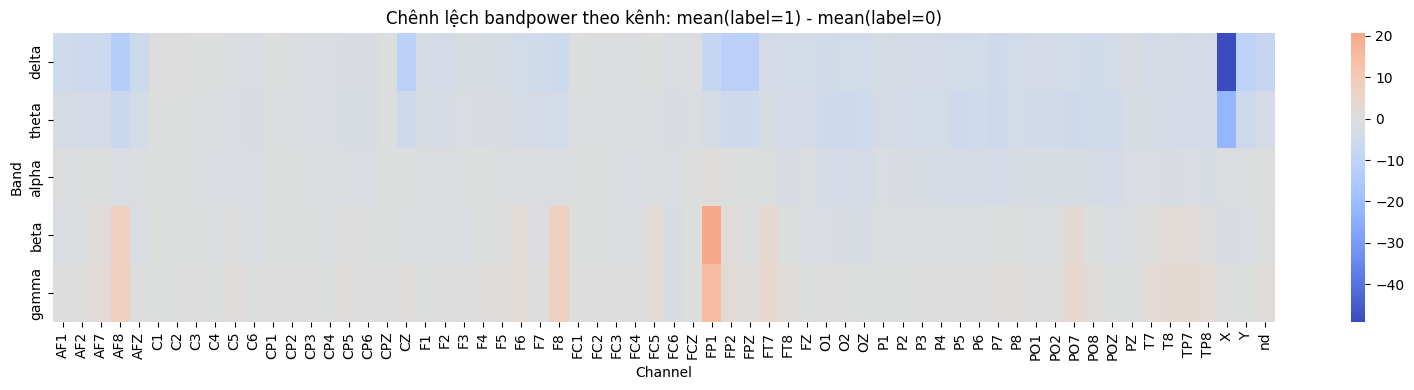

In [48]:
# Heatmap chênh lệch bandpower theo channel: mean(label=1) - mean(label=0)

# Parse channel names từ cột bp_...
channels_from_cols = sorted({c.split('_', 2)[2] for c in bp_cols_ref})

# Tạo ma trận (band, channel)
diff_mat = np.zeros((len(BANDS), len(channels_from_cols)), dtype=np.float32)

for bi, b in enumerate(BANDS.keys()):
    for ci, ch in enumerate(channels_from_cols):
        col = f'bp_{b}_{ch}'
        if col not in bp_df.columns:
            diff_mat[bi, ci] = np.nan
            continue
        m1 = bp_df.loc[bp_df['label'] == 1, col].mean()
        m0 = bp_df.loc[bp_df['label'] == 0, col].mean()
        diff_mat[bi, ci] = m1 - m0

plt.figure(figsize=(16, 4))
sns.heatmap(diff_mat, xticklabels=channels_from_cols, yticklabels=list(BANDS.keys()), cmap='coolwarm', center=0)
plt.title('Chênh lệch bandpower theo kênh: mean(label=1) - mean(label=0)')
plt.xlabel('Channel')
plt.ylabel('Band')
plt.tight_layout()
plt.show()

In [49]:
# Top-k channels khác biệt nhất theo từng band (theo |mean1-mean0|)
TOPK = 10

for b in BANDS.keys():
    diffs = []
    for ch in channels_from_cols:
        col = f'bp_{b}_{ch}'
        if col not in bp_df.columns:
            continue
        m1 = bp_df.loc[bp_df['label'] == 1, col].mean()
        m0 = bp_df.loc[bp_df['label'] == 0, col].mean()
        diffs.append((ch, m1 - m0))

    diffs = sorted(diffs, key=lambda x: abs(x[1]), reverse=True)[:TOPK]
    print('====', b, '====')
    print(pd.DataFrame(diffs, columns=['channel', 'mean_diff(label1-label0)']))


==== delta ====
  channel  mean_diff(label1-label0)
0       X                -49.107571
1     AF8                -12.813103
2     FPZ                -11.898521
3     FP2                -11.828476
4      CZ                -11.434006
5       Y                -10.396555
6     FP1                 -8.332294
7      nd                 -8.165745
8     AF7                 -6.316380
9     AF2                 -6.014905
==== theta ====
  channel  mean_diff(label1-label0)
0       X                -22.278088
1     AF8                 -6.816718
2       Y                 -6.267212
3      P7                 -6.135805
4     FP2                 -5.582561
5     FPZ                 -5.426576
6      P5                 -5.351112
7      CZ                 -5.263191
8      O1                 -5.123898
9     PO7                 -5.071501
==== alpha ====
  channel  mean_diff(label1-label0)
0      P7                 -3.543375
1      P5                 -3.225050
2      O2                 -3.179241
3     POZ       

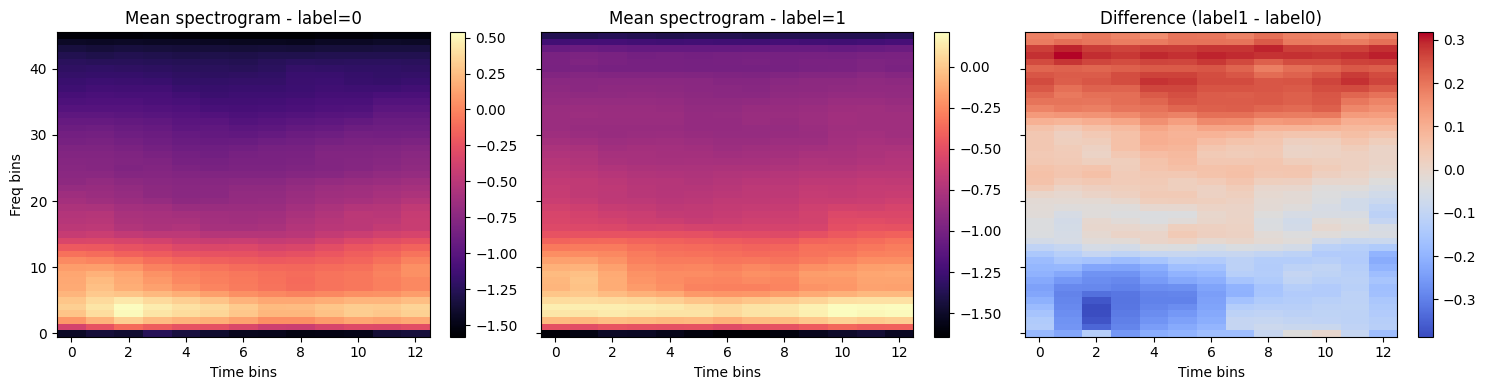

In [50]:
# Spectrogram trung bình theo nhãn + ảnh chênh lệch
# X_spec: (N, F, T, 1)

if 'X_spec' not in globals():
    raise ValueError('Chưa có X_spec. Hãy chạy cell build dataset (tạo X_spec) trước.')

S0 = X_spec[y == 0].mean(axis=0).squeeze(-1)  # (F,T)
S1 = X_spec[y == 1].mean(axis=0).squeeze(-1)
Sd = S1 - S0

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

im0 = axes[0].imshow(S0, aspect='auto', origin='lower', cmap='magma')
axes[0].set_title('Mean spectrogram - label=0')
fig.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(S1, aspect='auto', origin='lower', cmap='magma')
axes[1].set_title('Mean spectrogram - label=1')
fig.colorbar(im1, ax=axes[1], fraction=0.046)

im2 = axes[2].imshow(Sd, aspect='auto', origin='lower', cmap='coolwarm')
axes[2].set_title('Difference (label1 - label0)')
fig.colorbar(im2, ax=axes[2], fraction=0.046)

for ax in axes:
    ax.set_xlabel('Time bins')
axes[0].set_ylabel('Freq bins')
plt.tight_layout()
plt.show()

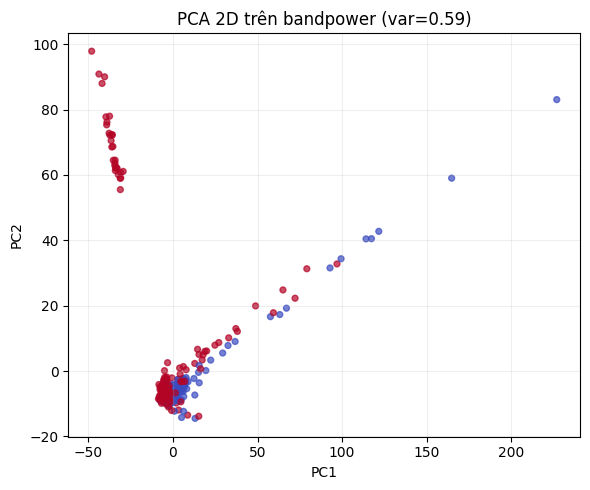

In [51]:
# PCA 2D trên feature bandpower để nhìn mức phân tách
from sklearn.decomposition import PCA

Xbp_s = RobustScaler().fit_transform(X_bp)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z = pca.fit_transform(Xbp_s)

plt.figure(figsize=(6, 5))
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='coolwarm', alpha=0.7, s=18)
plt.title(f'PCA 2D trên bandpower (var={pca.explained_variance_ratio_.sum():.2f})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

#### 3.1 Đánh giá 4 mô hình

In [52]:
# Tổng hợp so sánh các mô hình từ `results`
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

rows = []
for name, obj in results.items():
    y_pred = obj.get('y_pred', None)
    y_prob = obj.get('y_prob', None)
    if y_pred is None:
        continue
    acc = float(accuracy_score(y_test, y_pred))
    auc = None
    if y_prob is not None:
        try:
            auc = float(roc_auc_score(y_test, y_prob))
        except Exception:
            auc = None
    rows.append({'model': name, 'accuracy': acc, 'roc_auc': auc})

metrics_df = pd.DataFrame(rows).sort_values(['roc_auc', 'accuracy'], ascending=False)
metrics_df


,model,accuracy,roc_auc
2,XGBoost (Bandpower),0.969298,0.996747
4,ANN/MLP (Bandpower),0.978070,0.994669
1,Random Forest (Bandpower),0.947368,0.990146
0,Logistic Regression (Bandpower),0.978070,0.988472
3,KNN (Bandpower),0.923246,0.985566
5,EfficientNetB0 TL (Spectrogram),0.831140,0.893281


In [53]:
# (ĐÃ CHUYỂN) KNN đã được train/đánh giá ở phía trên theo format 2 cell/model.
# Cell này giữ trống để tránh chạy lại bị trùng.
